In [25]:
# ! pip install jupyter openpyxl seaborn matplotlib
# ! pip install -U sentence-transformers
# ! pip3 install alibi scikit-learn-extra
# ! pip3 install wordcloud

In [26]:
import datetime
import sys

print(f"UTC now= '{datetime.datetime.utcnow().isoformat().split('.')[0]}'")
print(f'Virtualenv used: {sys.executable}')

import importlib


import numpy as np
import pandas as pd
import ast
import pickle
import math

from pathlib import Path

from sklearn.cluster import KMeans

#for text pre-processing
import re, string

from sklearn.decomposition import TruncatedSVD
# bag of words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier
#for model-building
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix,roc_curve,auc
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree

from sentence_transformers import SentenceTransformer
sentence_bert_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

import spacy
importlib.reload(spacy)
spacy_nlp_model = spacy.load('en_core_web_lg')

from scipy.optimize import minimize_scalar

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Initialize the lemmatizer
wl = WordNetLemmatizer()

from nltk.corpus import wordnet, stopwords

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# for LIME import necessary packages
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
from random import randint

from typing import List, Optional

UTC now= '2022-05-10T19:54:40'
Virtualenv used: /usr/bin/python3


[nltk_data] Downloading package punkt to
[nltk_data]     /home/mmozolewski/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mmozolewski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mmozolewski/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/mmozolewski/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/mmozolewski/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [27]:
def _save_pickle(df, outfile, results_folder):
  if results_folder:
    results_folder_local = f"{str(Path('~').expanduser().resolve())}/{results_folder}"
    # results_folder_local = results_folder
  else:
    results_folder_local = f"{str(Path('~').expanduser().resolve())}/data"
  Path(results_folder_local).mkdir(parents=True, exist_ok=True)
  fname = f"{results_folder_local}/{outfile}.pickle"
  print(fname)
  with open(fname, 'wb') as f:
    pickle.dump(df, f)


def get_LSA(df:pd.DataFrame, column_to_omit:str, variance:float):

  def get_LSA_variance(how_many_dimension):
    how_many_dimension = math.floor(how_many_dimension)
    svd = TruncatedSVD(how_many_dimension)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    lsa.fit_transform(_df)
    return svd.explained_variance_ratio_.sum()*100

  def get_LSA_delta(how_many_dimension):
    explained_variance = get_LSA_variance(how_many_dimension)
    delta = round(math.fabs(explained_variance - variance), 0)
    # print(f"how_many_dimension= {how_many_dimension}, explained_variance= {explained_variance}, delta= {delta}")
    return delta

  def optimize_how_many_dimension(bounds):
    res = minimize_scalar(get_LSA_delta, bounds=bounds, method='bounded')
    # print(res.x)
    how_many_dimension = math.floor(res.x)
    if get_LSA_variance(how_many_dimension) < variance:
      how_many_dimension += 1
    return (how_many_dimension-1, get_LSA_variance(how_many_dimension))

  _df = df.loc[:, (df.columns != column_to_omit) & (df.columns != 'cluster_kmeans')]
  variables_max_count = len(_df.columns) - 1
  how_many_dimension, explained_variance = optimize_how_many_dimension(bounds=(1, variables_max_count/4))
  if explained_variance < variance:
    print(f"variance is to low: {explained_variance}")
    how_many_dimension, explained_variance = optimize_how_many_dimension(bounds=(how_many_dimension+1, variables_max_count/2))
  if explained_variance < variance:
    print(f"variance is to low: {explained_variance}")
    how_many_dimension, explained_variance = optimize_how_many_dimension(bounds=(how_many_dimension+1, variables_max_count))

  while get_LSA_variance(how_many_dimension) < variance:
    how_many_dimension += 1

  svd = TruncatedSVD(how_many_dimension)
  normalizer = Normalizer(copy=False)
  lsa = make_pipeline(svd, normalizer)
  _df_lsa = pd.DataFrame(lsa.fit_transform(_df))
  print(f"explained variance perc = {svd.explained_variance_ratio_.sum()*100}%")

  if 'cluster_kmeans' in df.columns:
    _df_lsa = pd.concat([df[['article_which_cities', 'cluster_kmeans']], _df_lsa], axis=1, join="inner")
  else:
    _df_lsa = pd.concat([df[['article_which_cities']], _df_lsa], axis=1, join="inner")
  # df_edges_lsa['cluster_kmeans'] = -1
  return _df_lsa

# get_LSA(df_edges_one_hot, 'article_which_cities', 95.0)


def k_means(df, column_to_ommit, how_many_clusters):
  kmeans = KMeans(n_clusters=how_many_clusters, random_state=2022).fit(df.loc[:, (df.columns != column_to_ommit) & (df.columns != 'cluster_kmeans')])
  # kmeans.labels_
  # print(pd.DataFrame(kmeans.cluster_centers_).reset_index())
  # print(pd.DataFrame(kmeans.cluster_centers_).reset_index()['index'])
  df['cluster_kmeans'] = kmeans.labels_
  # df_only_one_hots = df.loc[:, (df.columns != 'article_which_cities') & (df.columns != 'cluster_kmeans')]
  # df[['article_which_cities', 'cluster_kmeans']]
  return df


def get_TSNE_and_PCA_embeddings(df_edges, column_to_ommit):
  df_edges_independent_vars = df_edges.loc[:, (df_edges.columns != column_to_ommit) & (df_edges.columns != 'cluster_kmeans')]

  df_tsne = pd.DataFrame(TSNE(n_components=2).fit_transform(df_edges_independent_vars))
  df_tsne['cluster'] = df_edges['cluster_kmeans']
  df_tsne.columns = ['x1', 'x2', 'cluster']
  df_tsne['article_which_cities'] = df_edges['article_which_cities']

  df_pca = pd.DataFrame(PCA(n_components=2).fit_transform(df_edges_independent_vars))
  df_pca['cluster'] = df_edges['cluster_kmeans']
  df_pca.columns = ['x1', 'x2', 'cluster']
  df_pca['article_which_cities'] = df_edges['article_which_cities']

  scaler = MinMaxScaler()
  df_tsne[['x1', 'x2']] = scaler.fit_transform(df_tsne[['x1', 'x2']])
  df_pca[['x1', 'x2']] = scaler.fit_transform(df_pca[['x1', 'x2']])

  return df_tsne, df_pca


def wrap_by_word(s, n):
  '''returns a string where \\n is inserted between every n words'''
  if isinstance(s, str):
    a = s.split()
    ret = ''
    for i in range(0, len(a), n):
      ret += ' '.join(a[i:i+n]) + '\n'

    return ret
  return ""

# x = wrap_by_word('There is a dog and fox fighting in the park and there is an apple falling down.', 4)
# print(x)
def get_article_info(df_with_article_which_cities_column, column):
  df_nodes_cp = df_nodes.copy()
  df_nodes_cp['article_which_cities'] = df_nodes_cp['ID']#.apply(lambda x: f"{x:02d}")
  df_merged = df_with_article_which_cities_column.merge(df_nodes_cp, on='article_which_cities', how='left')

  return df_merged['article_which_cities'] + " (" + df_merged['Year'].apply(lambda x: str(int(x)) if not np.isnan(x) else "") + ") " + ": \n" + df_merged[column].apply(lambda x: wrap_by_word(x, 3))


def label_point(x, y, val, ax, factor):
  a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
  for i, point in a.iterrows():
    ax.text(point['x'] + 1*factor, point['y'] - 10*factor, str(point['val']))


def visualise_clusters(df_2d_embedding, factor=1/200, base_size=6):
  _fig, _ax = plt.subplots(1, 1, figsize=(base_size*4,base_size*2))
  sns.scatterplot(data=df_2d_embedding, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, s=120, palette="deep", ax=_ax)
  label_point(df_2d_embedding['x1'], df_2d_embedding['x2'], get_article_info(df_2d_embedding, column='Title'), _ax, factor)
  # display(_fig)

# get_article_info(df_edges_lsa_tsne, column='Title')

In [28]:
# df_nodes = pd.read_excel('/media/mmozolewski/m.mozolewski@gma/Documents/Doktorat/Parisa/xai-survey/RC6 nodes info(Abstract).xlsx', sheet_name=0)
# df_edges = pd.read_excel('/media/mmozolewski/m.mozolewski@gma/Documents/Doktorat/Parisa/xai-survey/Data.xlsx', sheet_name=0)

# df_nodes = pd.read_excel('notebooks/xai-survey/RC6 nodes info(Abstract).xlsx', sheet_name=0)
# df_edges = pd.read_excel('notebooks/xai-survey/Data.xlsx', sheet_name=0)

df_nodes = pd.read_excel('notebooks/xai-survey/intents_500.xlsx', sheet_name=1)
# df_edges = pd.read_csv('notebooks/xai-survey/All_ref_500.csv') ## CORRUPTED
df_edges_pivot = pd.read_excel('notebooks/xai-survey/intents_500.xlsx', sheet_name=0)
print(f"\n {str(df_nodes.info())}")
print(f"\n{str(df_edges_pivot.info())}")

LEADING_ZEROS = 3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     500 non-null    float64
 1   PaperId        499 non-null    object 
 2   Title          500 non-null    object 
 3   Year           500 non-null    float64
 4   CitationCount  500 non-null    float64
 5   Abstract       525 non-null    object 
dtypes: float64(3), object(3)
memory usage: 27.7+ KB

 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 501 entries, Unnamed: 0 to 500
dtypes: float64(141), int64(1), object(359)
memory usage: 1.9+ MB

None


In [29]:
LSA_VARIANCE = 90.0

In [30]:
df_nodes.rename(columns={'Unnamed: 0': "ID"}, inplace=True)
df_nodes['ID'] = df_nodes['ID'].apply(lambda x: str(int(x)).zfill(LEADING_ZEROS) if not np.isnan(x) else "-1") #
df_nodes['RepetitionCount'] = -1 # np.NAN
df_nodes['Year'] = df_nodes['Year'].apply(lambda x: int(x) if not np.isnan(x) else np.NaN) #
# df_nodes['Year'] = df_nodes['Year'].astype(int)
# df_nodes['Year'] = df_nodes['Year'].apply(lambda x: np.NAN if x == -1 else x) #
df_nodes['CitationCount'] = df_nodes['CitationCount'].apply(lambda x: int(x) if not np.isnan(x) else np.NaN) #
df_nodes['TitleAndAbstract'] = df_nodes['Title'] + ' ' + df_nodes['Abstract']

df_nodes = df_nodes[['ID', 'PaperId', 'Title', 'Abstract', 'TitleAndAbstract', 'Year', 'CitationCount', 'RepetitionCount']]
df_nodes.loc[df_nodes['Title'].isna(), ]

ID                                   PaperId Title  \
56   057  d891dc72cbd40ffaeefdc79f2e7afe1e530a23ad   NaN   
58   059  5b3791047274b9fb7a89bc28f69c70bbd4c4843e   NaN   
59   060  35db1c68ac5ac1156ef3df48e5fe7d7ded2689df   NaN   
110  111  9e717a6b761f4bd5e7d57be563d6fa8efe62b186   NaN   
114  115  0064efdb8008e433c4a18eb6f17c157f12742dc3   NaN   
..   ...                                       ...   ...   
488  489  6cfb794576e9ac08c185f22785669a6ae3d1b015   NaN   
490  491  6af2408d636b75b9084a996c015a5ab477090a46   NaN   
491  492  40bc08ec10f802fb93c90b66894b619976991ed1   NaN   
532   -1                                       NaN   NaN   
533   -1                                       NaN   NaN   

                                              Abstract TitleAndAbstract  Year  \
56    We present the first large-scale empirical co...              NaN   NaN   
58   First, we find that there is no distinction be...              NaN   NaN   
59   Second, we find that deep neural networks lear...              NaN   NaN   
110  Most of the current explanation methods provid...              NaN   NaN   
114                                                                 NaN   NaN   
..                                                 ...              ...   ...   
488  At a psychological model, NEOMYCIN captures th...              NaN   NaN   
490                                                                 NaN   NaN   
491  The XPLAIN system uses an automatic programmer...              NaN   NaN   
532                                                                 NaN   NaN   
533  The multi-armed bandit problem arises in seque...              NaN   NaN   

     CitationCount  RepetitionCount  
56             NaN               -1  
58             NaN               -1  
59             NaN               -1  
110            NaN               -1  
114            NaN               -1  
..             ...              ...  
488            NaN               -1  
490            NaN               -1  
491            NaN               -1  
532            NaN               -1  
533            NaN               -1  

[89 rows x 8 columns]

In [31]:
all_stopwords = spacy_nlp_model.Defaults.stop_words
print(len(all_stopwords))
print('approach' in all_stopwords)

all_stopwords.update(['et', 'al', 'approach', 'model', 'models', 'method', 'i', 'we', 'you', 'they']) ## TODO get better list from bigger corpus of abstracts
print(len(all_stopwords))
print('explanation' in all_stopwords)

all_stopwords.update(stopwords.words('english'))
print(len(all_stopwords))

388
True
388
False
388


In [32]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
  text = text.lower()
  text = text.strip()
  text = re.compile('<.*?>').sub('', text)
  text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
  text = re.sub('\s+', ' ', text)
  text = re.sub(r'\[[0-9]*\]', ' ', text)
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
  text = re.sub(r'\d', ' ', text)
  text = re.sub(r'\s+', ' ', text)
  text = ' '.join([i for i in text.split() if i not in list(all_stopwords)])
  return text


#LEMMATIZATION
# function to map NTLK position tags
def get_wordnet_pos(tag):
  if tag.startswith('J'):
    return wordnet.ADJ
  elif tag.startswith('V'):
    return wordnet.VERB
  elif tag.startswith('N'):
    return wordnet.NOUN
  elif tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN


# Tokenize the sentence
def lemmatizer(string):
  word_pos_tags = nltk.pos_tag(word_tokenize(string))  # Get position tags
  a = [wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]  # Map the position tag and lemmatize the word/token
  return " ".join(a)


def finalpreprocess(text):
  return lemmatizer(preprocess(text))


df_nodes['AbstractCleaned'] = df_nodes['Abstract'].apply(lambda x: finalpreprocess(x) if isinstance(x, str) and x != "" else np.NaN)
df_nodes

ID                                   PaperId  \
0    001  5091316bb1c6db6c6a813f4391911a5c311fdfe0   
1    002  17a273bbd4448083b01b5a9389b3c37f5425aac0   
2    003  5c39e37022661f81f79e481240ed9b175dec6513   
3    004  442e10a3c6640ded9408622005e3c2a8906ce4c2   
4    005  f302e136c41db5de1d624412f68c9174cf7ae8be   
..   ...                                       ...   
584   -1                                       NaN   
585   -1                                       NaN   
586   -1                                       NaN   
587   -1                                       NaN   
588   -1                                       NaN   

                                                 Title  \
0    "Why Should I Trust You?": Explaining the Pred...   
1    On Pixel-Wise Explanations for Non-Linear Clas...   
2    Towards A Rigorous Science of Interpretable Ma...   
3    A Unified Approach to Interpreting Model Predi...   
4              Axiomatic Attribution for Deep Networks   
..                                                 ...   
584                    Learning Why by Being Told What   
585                   The Construction of Explanations   
586                                     Design at Work   
587            An introduction to case-based reasoning   
588              What is an “Explanation” of Behavior?   

                                              Abstract  \
0    Despite widespread adoption, machine learning ...   
1    Understanding and interpreting classification ...   
2    As machine learning systems become ubiquitous,...   
3    Understanding why a model makes a certain pred...   
4    We study the problem of attributing the predic...   
..                                                 ...   
584  An approach to acquiring justification that tr...   
585  What sorts of processes are needed to construc...   
586  Contents: J. Greenbaum, M. Kyng, Preface: Memo...   
587  Case-based reasoning means using old experienc...   
588  The cognitive “revolution” in psychology intro...   

                                      TitleAndAbstract    Year  CitationCount  \
0    "Why Should I Trust You?": Explaining the Pred...  2016.0         5799.0   
1    On Pixel-Wise Explanations for Non-Linear Clas...  2015.0         1848.0   
2    Towards A Rigorous Science of Interpretable Ma...  2017.0         1598.0   
3    A Unified Approach to Interpreting Model Predi...  2017.0         3798.0   
4    Axiomatic Attribution for Deep Networks We stu...  2017.0         1749.0   
..                                                 ...     ...            ...   
584  Learning Why by Being Told What An approach to...  1991.0            9.0   
585  The Construction of Explanations What sorts of...  1991.0            2.0   
586  Design at Work Contents: J. Greenbaum, M. Kyng...  1992.0         2077.0   
587  An introduction to case-based reasoning Case-b...  1992.0          547.0   
588  What is an “Explanation” of Behavior? The cogn...  1992.0          383.0   

     RepetitionCount                                    AbstractCleaned  
0                 -1  despite widespread adoption machine learn rema...  
1                 -1  understand interpret classification decision a...  
2                 -1  machine learn system ubiquitous surge interest...  
3                 -1  understanding make certain prediction crucial ...  
4                 -1  study problem attribute prediction deep networ...  
..               ...                                                ...  
584               -1  acquire justification transforms question ques...  
585               -1  sort process need construct explanation aim de...  
586               -1  content j greenbaum kyng preface memory past j...  
587               -1  case base reasoning mean old experience unders...  
588               -1  cognitive revolution psychology introduce new ...  

[589 rows x 9 columns]

In [33]:
df_edges_pivot.rename(columns={'Unnamed: 0': "ID"}, inplace=True)
df_edges_pivot.tail(10)

ID    1    2    3    4    5    6    7    8    9  ...  491 492 493 494  \
490  491  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN NaN NaN NaN   
491  492  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN NaN NaN NaN   
492  493  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN NaN NaN NaN   
493  494  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN NaN NaN NaN   
494  495  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN NaN NaN NaN   
495  496  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN NaN NaN NaN   
496  497  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN NaN NaN NaN   
497  498  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN NaN NaN NaN   
498  499  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN NaN NaN NaN   
499  500  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN NaN NaN NaN   

    495 496  497  498 499 500  
490 NaN NaN  NaN  NaN NaN NaN  
491 NaN NaN  NaN  NaN NaN NaN  
492 NaN NaN  NaN  NaN NaN NaN  
493 NaN NaN  NaN  NaN NaN NaN  
494 NaN NaN  NaN  NaN NaN NaN  
495 NaN NaN  NaN  NaN NaN NaN  
496 NaN NaN  NaN  NaN NaN NaN  
497 NaN NaN  NaN  NaN NaN NaN  
498 NaN NaN  NaN  NaN NaN NaN  
499 NaN NaN  NaN  NaN NaN NaN  

[10 rows x 501 columns]

In [34]:
df_edges = df_edges_pivot.melt(id_vars=['ID'], value_name='link type').dropna(axis='rows')
df_edges.rename(columns={'ID' : 'node 1', 'variable' : 'node 2'}, inplace=True)
df_edges['link type'] = df_edges['link type'].apply(lambda x: "['unknown']" if x == "[]" else x)
df_edges['link type'] = df_edges['link type'].apply(lambda x: ast.literal_eval(x))

df_edges

node 1 node 2                          link type
12          13      1  [methodology, background, result]
19          20      1          [methodology, background]
25          26      1                       [background]
36          37      1                       [background]
44          45      1                       [background]
...        ...    ...                                ...
245419     420    491                          [unknown]
248421     422    497                          [unknown]
248422     423    497                          [unknown]
248436     437    497                          [unknown]
248472     473    497                          [unknown]

[3961 rows x 3 columns]

In [35]:
df_edges_any_link = df_edges[['node 1', 'node 2']].drop_duplicates()
df_edges_any_link['node 1'] = df_edges_any_link['node 1'].apply(lambda x: str(int(x)).zfill(LEADING_ZEROS) if not np.isnan(x) else "-1")
df_edges_any_link['node 2'] = df_edges_any_link['node 2'].apply(lambda x: str(int(x)).zfill(LEADING_ZEROS) if not np.isnan(x) else "-1")
df_edges_any_link

node 1 node 2
12        013    001
19        020    001
25        026    001
36        037    001
44        045    001
...       ...    ...
245419    420    491
248421    422    497
248422    423    497
248436    437    497
248472    473    497

[3961 rows x 2 columns]

# Clustering

## One-hot features

In [36]:
## id | is_methodology_01 | is_result_01 | is_result_01 |
## 00       true                false
# df_nodes['ID'] = df_nodes['ID'].apply(lambda x: str(int(x)).zfill(LEADING_ZEROS) if not np.isnan(x) else "-1")
df_edges_flatten = []
for index, row in df_edges.iterrows():
  for link_type in row['link type']:
    df_edges_flatten.append((str(int(row['node 1'])).zfill(LEADING_ZEROS), f"{str(int(row['node 2'])).zfill(LEADING_ZEROS)}_{link_type}", row['node 1'], row['node 2'], link_type))
df_edges_flatten = pd.DataFrame(df_edges_flatten)
df_edges_flatten.sort_values(by=[2, 3, 4], inplace=True)
df_edges_flatten

0                1    2    3            4
29    001      003_unknown    1    3      unknown
47    001  004_methodology    1    4  methodology
57    001   005_background    1    5   background
80    001      006_unknown    1    6      unknown
210   001      009_unknown    1    9      unknown
...   ...              ...  ...  ...          ...
4114  496      348_unknown  496  348      unknown
321   497      015_unknown  497   15      unknown
4115  497   348_background  497  348   background
4116  498      348_unknown  498  348      unknown
4117  500      348_unknown  500  348      unknown

[4654 rows x 5 columns]

In [37]:
# pd.pivot_table(df_edges_flatten, index=0, values=2, columns=1, aggfunc='-'.join)
df_edges_flatten_one_hot = pd.get_dummies(df_edges_flatten[1])
df_edges_flatten_one_hot = pd.concat([df_edges_flatten, df_edges_flatten_one_hot], axis=1, join="inner")
# df_edges_flatten_one_hot
df_edges_one_hot = df_edges_flatten_one_hot.groupby(0).agg(lambda x: x.sum()).reset_index()
df_edges_one_hot.rename(columns={0: "article_which_cities"}, inplace=True)
del df_edges_flatten_one_hot
del df_edges_one_hot[1]
del df_edges_one_hot[2]
del df_edges_one_hot[3]
del df_edges_one_hot[4]
# df_edges_one_hot['cluster_kmeans'] = -1
df_edges_one_hot

article_which_cities  001_background  001_methodology  001_result  \
0                    001               0                0           0   
1                    002               0                0           0   
2                    003               0                0           0   
3                    004               0                0           0   
4                    005               0                0           0   
..                   ...             ...              ...         ...   
456                  495               0                0           0   
457                  496               0                0           0   
458                  497               0                0           0   
459                  498               0                0           0   
460                  500               0                0           0   

     002_background  002_methodology  002_result  002_unknown  003_background  \
0                 0                0           0            0               0   
1                 0                0           0            0               0   
2                 0                0           0            0               0   
3                 0                0           0            0               0   
4                 0                0           0            0               0   
..              ...              ...         ...          ...             ...   
456               0                0           0            0               0   
457               0                0           0            0               0   
458               0                0           0            0               0   
459               0                0           0            0               0   
460               0                0           0            0               0   

     003_methodology  ...  473_methodology  473_result  473_unknown  \
0                  0  ...                0           0            0   
1                  0  ...                0           0            0   
2                  0  ...                0           0            0   
3                  0  ...                0           0            0   
4                  0  ...                0           0            0   
..               ...  ...              ...         ...          ...   
456                0  ...                0           0            0   
457                0  ...                0           0            0   
458                0  ...                0           0            0   
459                0  ...                0           0            0   
460                0  ...                0           0            0   

     476_unknown  480_unknown  485_unknown  487_unknown  488_background  \
0              0            0            0            0               0   
1              0            0            0            0               0   
2              0            0            0            0               0   
3              0            0            0            0               0   
4              0            0            0            0               0   
..           ...          ...          ...          ...             ...   
456            0            0            0            0               0   
457            0            0            0            0               0   
458            0            0            0            0               0   
459            0            0            0            0               0   
460            0            0            0            0               0   

     491_unknown  497_unknown  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  
..           ...          ...  
456            0            0  
457            0            0  
458            0            0  
459            0            0  
460            0            0  

[461 rows x 838

In [38]:
df_edges_any_link_dummies = pd.get_dummies(df_edges_any_link['node 2'])
df_edges_any_link_dummies = pd.concat([df_edges_any_link, df_edges_any_link_dummies], axis=1, join="inner")

df_edges_any_link_one_hot = df_edges_any_link_dummies.groupby('node 1').agg(lambda x: x.sum()).reset_index()
df_edges_any_link_one_hot.rename(columns={'node 1': "article_which_cities"}, inplace=True)
# df_edges_any_link_one_hot['cluster_kmeans'] = -1
del df_edges_any_link_dummies
del df_edges_any_link_one_hot['node 2']

df_edges_any_link_one_hot

article_which_cities  001  002  003  004  005  006  007  008  009  ...  \
0                    001    0    0    1    1    1    1    0    0    1  ...   
1                    002    0    0    0    1    0    1    0    0    0  ...   
2                    003    0    0    0    0    0    1    0    0    0  ...   
3                    004    0    0    0    0    0    0    0    0    0  ...   
4                    005    0    0    0    0    0    1    0    0    0  ...   
..                   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
456                  495    0    0    0    0    0    0    0    0    0  ...   
457                  496    0    0    0    0    0    0    0    0    0  ...   
458                  497    0    0    0    0    0    0    0    0    0  ...   
459                  498    0    0    0    0    0    0    0    0    0  ...   
460                  500    0    0    0    0    0    0    0    0    0  ...   

     466  471  473  476  480  485  487  488  491  497  
0      0    0    0    0    0    0    0    0    0    0  
1      0    0    0    0    0    0    0    0    0    0  
2      0    0    0    0    0    0    0    0    0    0  
3      0    0    0    0    0    0    0    0    0    0  
4      0    0    0    0    0    0    0    0    0    0  
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
456    0    0    0    0    0    0    0    0    0    0  
457    0    0    0    0    0    0    0    0    0    0  
458    0    0    0    0    0    0    0    0    0    0  
459    0    0    0    0    0    0    0    0    0    0  
460    0    0    0    0    0    0    0    0    0    0  

[461 rows x 360 columns]

## LSA features on One-HOT

In [39]:
df_edges_lsa = get_LSA(df_edges_one_hot, 'article_which_cities', LSA_VARIANCE)
df_edges_lsa

variance is to low: 89.98256931591222
explained variance perc = 90.65531729914076%


article_which_cities         0         1         2         3         4  \
0                    001  0.634516 -0.234383 -0.068200  0.547005 -0.249341   
1                    002  0.569256  0.032532 -0.447786 -0.206716  0.019696   
2                    003  0.440856 -0.365681  0.083492  0.135241 -0.202331   
3                    004  0.361971 -0.223263 -0.121653  0.165240  0.045174   
4                    005  0.497846 -0.102904 -0.388553 -0.019642  0.166040   
..                   ...       ...       ...       ...       ...       ...   
456                  495  0.012752 -0.034471  0.018521  0.011652 -0.013330   
457                  496  0.162492 -0.103944  0.003135 -0.615172 -0.528650   
458                  497  0.032381 -0.057499  0.009661  0.027643 -0.048731   
459                  498  0.162492 -0.103944  0.003135 -0.615172 -0.528650   
460                  500  0.162492 -0.103944  0.003135 -0.615172 -0.528650   

            5         6         7         8  ...           131       132  \
0    0.123371 -0.125935 -0.162471  0.119586  ... -1.390792e-07  0.001574   
1    0.022357 -0.253333  0.042110  0.348728  ...  1.816804e-03 -0.005936   
2    0.046586  0.212560  0.041870  0.265046  ...  7.858654e-03  0.000240   
3   -0.182918  0.191958 -0.118366  0.039012  ...  1.390535e-02 -0.012488   
4   -0.285133  0.276842  0.248935 -0.107900  ... -1.744655e-02 -0.019117   
..        ...       ...       ...       ...  ...           ...       ...   
456 -0.012634 -0.025127  0.000567 -0.049200  ... -2.604569e-02 -0.020151   
457  0.215799  0.289486 -0.262428  0.013860  ... -3.049163e-02 -0.008025   
458  0.007202 -0.048358 -0.030586 -0.020364  ...  2.816655e-02 -0.000364   
459  0.215799  0.289486 -0.262428  0.013860  ... -3.049163e-02 -0.008025   
460  0.215799  0.289486 -0.262428  0.013860  ... -3.049163e-02 -0.008025   

          133       134       135       136       137       138       139  \
0   -0.001038  0.000004 -0.000139  0.003509 -0.002949 -0.003560 -0.003127   
1   -0.002284  0.002350  0.000206 -0.001281  0.003894 -0.000322 -0.002697   
2    0.004149  0.001672 -0.019744  0.000946 -0.008916  0.003491 -0.013306   
3   -0.019968  0.007386 -0.003011 -0.023621  0.007947  0.010117  0.001209   
4    0.021483 -0.013412  0.016247  0.003144  0.003591  0.002261 -0.007852   
..        ...       ...       ...       ...       ...       ...       ...   
456  0.020373  0.005127 -0.003722  0.033286 -0.008615 -0.025890 -0.027288   
457 -0.035281  0.008279  0.007959  0.021355  0.019182 -0.012425  0.011366   
458  0.043389  0.021399  0.037583  0.017544  0.029815 -0.040384  0.001635   
459 -0.035281  0.008279  0.007959  0.021355  0.019182 -0.012425  0.011366   
460 -0.035281  0.008279  0.007959  0.021355  0.019182 -0.012425  0.011366   

          140  
0    0.000926  
1   -0.006643  
2   -0.005793  
3   -0.023991  
4    0.004685  
..        ...  
456 -0.042882  
457 -0.015365  
458 -0.041473  
459 -0.015365  
460 -0.015365  

[461 rows x 142 columns]

In [40]:
df_edges_any_link_lsa = get_LSA(df_edges_any_link_one_hot, 'article_which_cities', LSA_VARIANCE)
df_edges_any_link_lsa

variance is to low: 87.77969174123572
variance is to low: 89.71313563771706
explained variance perc = 90.44672282484409%


article_which_cities         0         1         2         3         4  \
0                    001  0.744518 -0.173076 -0.145005 -0.267754  0.108675   
1                    002  0.687183  0.080195 -0.112237 -0.104745 -0.203804   
2                    003  0.614288 -0.352558 -0.178349 -0.165290 -0.069073   
3                    004  0.538727 -0.261860 -0.154094 -0.379720 -0.084977   
4                    005  0.646974 -0.061084 -0.008832 -0.342313 -0.326893   
..                   ...       ...       ...       ...       ...       ...   
456                  495  0.162037 -0.113797 -0.592470  0.668979 -0.280446   
457                  496  0.162037 -0.113797 -0.592470  0.668979 -0.280446   
458                  497  0.142667 -0.113010 -0.496848  0.525428 -0.215982   
459                  498  0.162037 -0.113797 -0.592470  0.668979 -0.280446   
460                  500  0.162037 -0.113797 -0.592470  0.668979 -0.280446   

            5         6         7         8  ...        88        89  \
0    0.292595  0.083372  0.113802  0.018995  ... -0.017171  0.010530   
1   -0.293697  0.163385  0.048455  0.174593  ... -0.022547 -0.026301   
2    0.295629 -0.015834  0.067907  0.010255  ... -0.010612 -0.023247   
3    0.051603 -0.256176 -0.024680 -0.087816  ... -0.006980  0.033337   
4   -0.136123 -0.012693 -0.136464 -0.072302  ...  0.010003  0.026594   
..        ...       ...       ...       ...  ...       ...       ...   
456 -0.017789 -0.011343 -0.152158  0.015598  ...  0.001506  0.011491   
457 -0.017789 -0.011343 -0.152158  0.015598  ...  0.001506  0.011491   
458  0.000419 -0.024847 -0.087527  0.020824  ...  0.011892 -0.052685   
459 -0.017789 -0.011343 -0.152158  0.015598  ...  0.001506  0.011491   
460 -0.017789 -0.011343 -0.152158  0.015598  ...  0.001506  0.011491   

           90        91        92        93        94        95        96  \
0    0.021668  0.007413  0.005664  0.004471 -0.002890  0.006574  0.006949   
1    0.007283  0.031785  0.018508 -0.027918  0.020505  0.002881 -0.006387   
2    0.004608  0.008869  0.033448  0.035199 -0.024412  0.003225  0.008994   
3   -0.016534  0.002416 -0.017195 -0.006350 -0.030213 -0.003016  0.039519   
4    0.000883 -0.002516  0.004584  0.029486  0.007206 -0.017240  0.012682   
..        ...       ...       ...       ...       ...       ...       ...   
456 -0.009474  0.007633 -0.027207 -0.000085 -0.034746  0.018623  0.002502   
457 -0.009474  0.007633 -0.027207 -0.000085 -0.034746  0.018623  0.002502   
458 -0.024383 -0.040866  0.040924 -0.032029 -0.051901 -0.015856  0.052561   
459 -0.009474  0.007633 -0.027207 -0.000085 -0.034746  0.018623  0.002502   
460 -0.009474  0.007633 -0.027207 -0.000085 -0.034746  0.018623  0.002502   

           97  
0   -0.005582  
1   -0.036838  
2    0.002986  
3   -0.025989  
4   -0.032399  
..        ...  
456 -0.004671  
457 -0.004671  
458 -0.020912  
459 -0.004671  
460 -0.004671  

[461 rows x 99 columns]

# Sentence-BERT embeddings

In [41]:
def get_sentence_bert(df_nodes, column_with_text='Abstract'):
  df_embedings = pd.DataFrame(sentence_bert_model.encode(df_nodes[column_with_text].apply(lambda x: x if not pd.isna(x) else "").tolist()))
  df_embedings = pd.concat([df_nodes[['ID', column_with_text]], df_embedings], axis=1, join="inner").rename(columns={'ID': 'article_which_cities'}).dropna()
  del df_embedings[column_with_text]

  return df_embedings

df_nodes_abstract_bert = get_sentence_bert(df_nodes, column_with_text='Abstract')
df_nodes_abstract_bert.tail(5)

article_which_cities         0         1         2         3         4  \
584                   -1 -0.017296  0.048692 -0.019024 -0.012263  0.098146   
585                   -1  0.016123  0.017984 -0.026468 -0.025806  0.035215   
586                   -1 -0.028678  0.019534 -0.017830 -0.053457  0.056367   
587                   -1  0.052645  0.005579 -0.005766 -0.011859  0.063332   
588                   -1 -0.008968 -0.092152  0.001259 -0.053107  0.102925   

            5         6         7         8  ...       502       503  \
584  0.034771  0.039190 -0.018406 -0.031527  ... -0.032102  0.004830   
585 -0.052179 -0.031694 -0.016519  0.012909  ...  0.033544  0.037996   
586  0.029732 -0.051736  0.032582 -0.069190  ... -0.014056  0.005646   
587  0.036463 -0.032921 -0.005452  0.035590  ... -0.047974  0.043819   
588 -0.000792 -0.058408 -0.010706  0.031768  ... -0.029828 -0.009540   

          504       505       506       507       508       509       510  \
584 -0.012929 -0.073732  0.003356 -0.017276 -0.011276  0.051557  0.036233   
585 -0.000162 -0.036175  0.040448 -0.065337 -0.060667 -0.012349 -0.022638   
586  0.042084 -0.017343  0.014019  0.048505  0.046113 -0.024232 -0.018168   
587 -0.018127 -0.022445 -0.029737 -0.034865 -0.063325 -0.042784  0.048175   
588 -0.046247 -0.029585  0.046689 -0.037882 -0.053310  0.033808  0.003471   

          511  
584 -0.014990  
585 -0.025364  
586 -0.050235  
587  0.019550  
588  0.026081  

[5 rows x 513 columns]

## LSA features on Sentence-BERT embeddings

In [42]:
df_nodes_abstract_bert_lsa = get_LSA(df_nodes_abstract_bert, 'article_which_cities', LSA_VARIANCE)  # 55
df_nodes_abstract_bert_lsa

variance is to low: 88.6683702468872
variance is to low: 89.90887999534607
explained variance perc = 90.4732346534729%


article_which_cities         0         1         2         3         4  \
0                    001  0.662232 -0.396193 -0.093118  0.426544 -0.056483   
1                    002  0.605870 -0.120525  0.126336 -0.046334 -0.083980   
2                    003  0.635992 -0.301355  0.358641  0.100439 -0.002387   
3                    004  0.657348 -0.348785 -0.320779  0.132084  0.017142   
4                    005  0.709296  0.138043 -0.160443 -0.131428  0.026092   
..                   ...       ...       ...       ...       ...       ...   
519                   -1  0.418391 -0.153907 -0.110377 -0.241519  0.097888   
520                   -1  0.315853 -0.100493  0.119728 -0.184451 -0.011365   
521                   -1  0.503223 -0.205713  0.051788 -0.212774  0.120411   
523                   -1  0.431138 -0.213146  0.027857 -0.190636  0.044085   
524                   -1  0.527947  0.101816  0.140361 -0.105071  0.059806   

            5         6         7         8  ...       123       124  \
0   -0.036184  0.182986 -0.066749  0.087424  ... -0.014580  0.006621   
1    0.441859  0.139668 -0.023937  0.180410  ... -0.024859 -0.000076   
2   -0.005564  0.029164  0.085109  0.100828  ...  0.006378  0.029080   
3   -0.170459  0.071267 -0.070908 -0.178027  ... -0.015635  0.053803   
4   -0.004844  0.119450 -0.014681 -0.029722  ... -0.003120  0.017461   
..        ...       ...       ...       ...  ...       ...       ...   
519 -0.144287  0.036301 -0.261865  0.127264  ... -0.091062  0.074113   
520 -0.047400 -0.030311 -0.098952  0.154650  ...  0.077191 -0.057845   
521 -0.089280 -0.066960 -0.104939  0.150358  ...  0.005081 -0.080507   
523 -0.098539  0.103399 -0.195520  0.216348  ... -0.023564  0.000254   
524 -0.174051 -0.182680 -0.118861  0.061968  ... -0.029379  0.021364   

          125       126       127       128       129       130       131  \
0   -0.012282 -0.027628  0.028371 -0.018389 -0.030224  0.008274 -0.010440   
1   -0.004854 -0.025801 -0.046876 -0.013906  0.002621  0.024882  0.030409   
2    0.006658  0.033640  0.003059  0.030078  0.007658 -0.032645  0.017280   
3    0.011947 -0.030622  0.000631  0.024773 -0.018800  0.032034  0.011660   
4   -0.045910 -0.038895 -0.000102 -0.020461 -0.018652 -0.019668 -0.022396   
..        ...       ...       ...       ...       ...       ...       ...   
519 -0.023321  0.006018 -0.060948 -0.021351  0.065634 -0.013781  0.035605   
520  0.011766 -0.039420  0.057686  0.040894  0.000123 -0.033340  0.022024   
521  0.039084 -0.053576 -0.006460  0.064050 -0.015685  0.079028 -0.021426   
523 -0.003283  0.051540 -0.057517  0.004112  0.063231 -0.039009  0.009344   
524  0.060858 -0.016058  0.005791  0.036614 -0.047059  0.038358 -0.019228   

          132  
0    0.009908  
1    0.003126  
2    0.035700  
3    0.014711  
4   -0.045945  
..        ...  
519 -0.065417  
520 -0.049667  
521  0.070690  
523 -0.005884  
524  0.032805  

[469 rows x 134 columns]

# SpaCy embeddings

In [43]:
def get_spacy(df_nodes, column_with_text='Abstract'):
  df_embedings = pd.DataFrame([doc.vector for doc in spacy_nlp_model.pipe([str(x) for x in df_nodes[column_with_text].apply(lambda x: x if not pd.isna(x) else "").tolist()])])
  df_embedings = pd.concat([df_nodes[['ID', column_with_text]], df_embedings], axis=1, join="inner").rename(columns={'ID': 'article_which_cities'}).dropna()
  del df_embedings[column_with_text]

  return df_embedings

df_nodes_abstract_spacy = get_spacy(df_nodes, column_with_text='Abstract')
df_nodes_abstract_spacy.tail(5)

article_which_cities         0         1         2         3         4  \
584                   -1 -0.048281  0.179049 -0.083773 -0.031826 -0.007335   
585                   -1 -0.073420  0.108827 -0.187718 -0.054642 -0.056942   
586                   -1 -0.037036  0.182761 -0.058805 -0.065442  0.028469   
587                   -1 -0.078722  0.157737 -0.201199 -0.060131 -0.014128   
588                   -1 -0.018259  0.113338 -0.081568 -0.084374  0.029689   

            5         6         7         8  ...       290       291  \
584  0.084407  0.017701  0.034185 -0.049460  ... -0.189555  0.047092   
585  0.058758  0.007964  0.049201  0.005743  ... -0.254373  0.094728   
586  0.103076  0.065942 -0.054244 -0.033644  ... -0.072380 -0.031700   
587  0.001365  0.000356 -0.055513  0.033164  ... -0.250615  0.022961   
588  0.084731 -0.019438  0.031952 -0.047320  ... -0.219570  0.053226   

          292       293       294       295       296       297       298  \
584 -0.026420 -0.018002  0.010594  0.015674 -0.063984 -0.006200  0.014894   
585  0.014661  0.004584  0.005123 -0.044458 -0.029295 -0.033225  0.076768   
586 -0.082298  0.015001 -0.044082  0.035110  0.021743  0.022343 -0.117919   
587  0.030672  0.001609 -0.039664 -0.023870  0.009020 -0.077736  0.055301   
588 -0.011847  0.019600 -0.044346  0.047009  0.051454 -0.040778 -0.043572   

          299  
584  0.110022  
585  0.086434  
586  0.058749  
587  0.108033  
588  0.068769  

[5 rows x 301 columns]

## LSA for SpaCy

In [44]:
df_nodes_abstract_spacy_lsa = get_LSA(df_nodes_abstract_spacy, 'article_which_cities', LSA_VARIANCE)
df_nodes_abstract_spacy_lsa

explained variance perc = 90.22169709205627%


article_which_cities         0         1         2         3         4  \
0                    001  0.993883 -0.018193 -0.014990  0.027623  0.019422   
1                    002  0.995931 -0.000327 -0.001581 -0.023473  0.033305   
2                    003  0.991540  0.000429 -0.006385  0.057864 -0.025134   
3                    004  0.995925 -0.003518  0.005755 -0.017068  0.016899   
4                    005  0.992702 -0.001464 -0.041572 -0.011415  0.048279   
..                   ...       ...       ...       ...       ...       ...   
519                   -1  0.980700 -0.021691  0.044589  0.061535 -0.019130   
520                   -1  0.979997 -0.029030 -0.066965  0.082894  0.004415   
521                   -1  0.989737 -0.042056 -0.021104  0.079700 -0.011153   
523                   -1  0.977264 -0.013138 -0.042646  0.032584 -0.009889   
524                   -1  0.971532 -0.016976 -0.044853  0.111284  0.000144   

            5         6         7         8  ...        22        23  \
0   -0.005902 -0.020214 -0.010449  0.009473  ... -0.000319  0.021928   
1    0.033216 -0.003079  0.023349 -0.026592  ... -0.009883 -0.009845   
2    0.011973 -0.020212  0.007144  0.029358  ...  0.030819 -0.024154   
3    0.015225 -0.026068 -0.013223  0.004197  ... -0.003675  0.020372   
4   -0.009382 -0.015180 -0.011720  0.012628  ... -0.009328  0.006150   
..        ...       ...       ...       ...  ...       ...       ...   
519 -0.030566 -0.017725 -0.012527 -0.083015  ...  0.047351  0.027487   
520 -0.028415  0.012908 -0.035960  0.038098  ... -0.047562 -0.042119   
521 -0.040334 -0.027998 -0.019660  0.003222  ...  0.003276 -0.003106   
523 -0.056366  0.026265 -0.041573  0.021128  ... -0.037323 -0.036361   
524 -0.014182 -0.015964  0.028321 -0.007354  ...  0.036481  0.034702   

           24        25        26        27        28        29        30  \
0    0.012220  0.017931 -0.045974  0.004624  0.022364 -0.016127  0.019221   
1   -0.031755 -0.012405  0.000471 -0.012406  0.006453 -0.008464 -0.009679   
2   -0.002980 -0.034773 -0.010538  0.018564  0.006095  0.002877 -0.009064   
3    0.011211  0.008381 -0.026852  0.014103 -0.012809  0.018474 -0.001432   
4   -0.000498 -0.005585 -0.044098 -0.007964 -0.024432  0.002360  0.020737   
..        ...       ...       ...       ...       ...       ...       ...   
519  0.047592  0.005830  0.014082  0.007557  0.004939  0.017536  0.003937   
520  0.002008  0.030682 -0.028891 -0.000206  0.033127  0.005478 -0.029746   
521  0.032762 -0.025671  0.028785  0.007302 -0.003252 -0.004710  0.007934   
523  0.027823  0.025801 -0.037736  0.035992  0.039575 -0.064532 -0.000005   
524  0.068182 -0.020054 -0.050576  0.021147  0.011835 -0.009163  0.010786   

           31  
0    0.004197  
1    0.001732  
2    0.009264  
3    0.002004  
4   -0.000777  
..        ...  
519 -0.015539  
520  0.009323  
521 -0.016099  
523  0.009123  
524 -0.011145  

[469 rows x 33 columns]

# K-means clustering

<AxesSubplot:title={'center':'Citations: any link type - One-hot'}, xlabel='x1', ylabel='x2'>

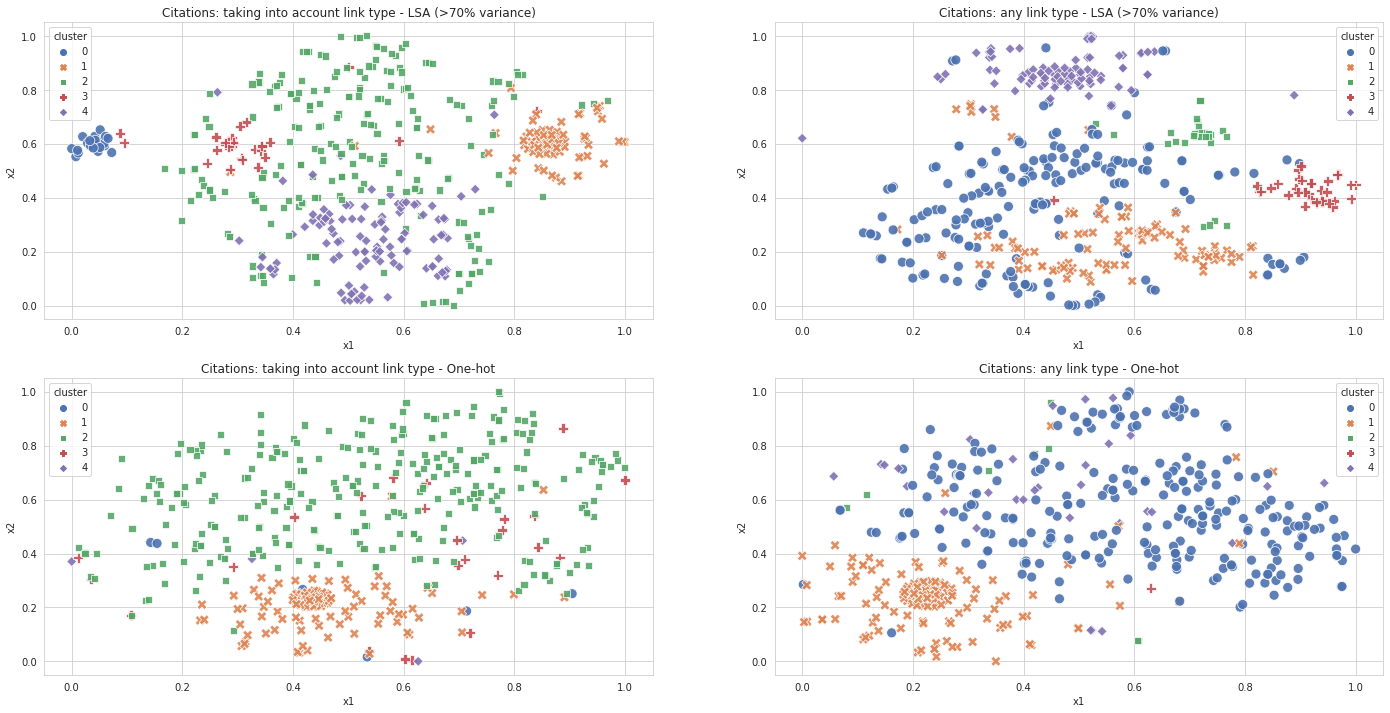

In [45]:
N_CLUSTERS = 5

df_edges_one_hot = k_means(df_edges_one_hot, 'article_which_cities', N_CLUSTERS)
df_edges_any_link_one_hot = k_means(df_edges_any_link_one_hot, 'article_which_cities', N_CLUSTERS)
df_edges_one_hot_tsne, _ = get_TSNE_and_PCA_embeddings(df_edges_one_hot, 'article_which_cities')
df_edges_any_link_one_hot_tsne, _ = get_TSNE_and_PCA_embeddings(df_edges_any_link_one_hot, 'article_which_cities')

df_edges_lsa = k_means(df_edges_lsa, 'article_which_cities', N_CLUSTERS)
df_edges_any_link_lsa = k_means(df_edges_any_link_lsa, 'article_which_cities', N_CLUSTERS)
df_edges_lsa_tsne, _ = get_TSNE_and_PCA_embeddings(df_edges_lsa, 'article_which_cities')
df_edges_any_link_lsa_tsne, _ = get_TSNE_and_PCA_embeddings(df_edges_any_link_lsa, 'article_which_cities')


fig, ax = plt.subplots(2, 2, figsize=(12*2,6*2))
ax[0,0].set_title('Citations: taking into account link type - LSA (>70% variance)')
sns.scatterplot(data=df_edges_lsa_tsne, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax[0,0])
ax[1,0].set_title('Citations: taking into account link type - One-hot')
sns.scatterplot(data=df_edges_one_hot_tsne, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax[1,0])

ax[0,1].set_title('Citations: any link type - LSA (>70% variance)')
sns.scatterplot(data=df_edges_any_link_lsa_tsne, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax[0,1])
ax[1,1].set_title('Citations: any link type - One-hot')
sns.scatterplot(data=df_edges_any_link_one_hot_tsne, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax[1,1])

# fig.suptitle('Clustering result: citations data (One-Hot, LSA) \n (visualized using TSNE2D vs. PCA2D)')

In [46]:
# df_edges_lsa_tsne
# df_nodes
# get_article_info(df_edges_lsa_tsne, column='Title')

In [ ]:
### some articles, like ... does not cite any other article, so they are not on this graph ###
# visualise_clusters(df_edges_any_link_lsa_tsne, base_size=7*6, factor=1/7 * 1/200)

In [125]:
# visualise_clusters(df_edges_lsa_tsne, base_size=7*6, factor=1/7 * 1/200)

## clustering on both citation data and spacy

In [49]:
df_edges_and_spacy_lsa = pd.merge(df_edges_lsa, df_nodes_abstract_spacy_lsa, on="article_which_cities")
del df_edges_and_spacy_lsa['cluster_kmeans']
df_edges_and_spacy_and_bert_lsa = pd.merge(df_edges_and_spacy_lsa, df_nodes_abstract_bert_lsa, on="article_which_cities")

print(len(df_edges_lsa.columns) + len(df_nodes_abstract_spacy_lsa.columns) + len(df_nodes_abstract_bert_lsa.columns) - 3)

df_edges_and_spacy_and_bert_lsa

307


article_which_cities       0_x       1_x       2_x       3_x       4_x  \
0                    001  0.634516 -0.234383 -0.068200  0.547005 -0.249341   
1                    002  0.569256  0.032532 -0.447786 -0.206716  0.019696   
2                    003  0.440856 -0.365681  0.083492  0.135241 -0.202331   
3                    004  0.361971 -0.223263 -0.121653  0.165240  0.045174   
4                    005  0.497846 -0.102904 -0.388553 -0.019642  0.166040   
..                   ...       ...       ...       ...       ...       ...   
407                  494  0.162492 -0.103944  0.003135 -0.615172 -0.528650   
408                  495  0.012752 -0.034471  0.018521  0.011652 -0.013330   
409                  497  0.032381 -0.057499  0.009661  0.027643 -0.048731   
410                  498  0.162492 -0.103944  0.003135 -0.615172 -0.528650   
411                  500  0.162492 -0.103944  0.003135 -0.615172 -0.528650   

          5_x       6_x       7_x       8_x  ...     123_y     124_y  \
0    0.123371 -0.125935 -0.162471  0.119586  ... -0.014580  0.006621   
1    0.022357 -0.253333  0.042110  0.348728  ... -0.024859 -0.000076   
2    0.046586  0.212560  0.041870  0.265046  ...  0.006378  0.029080   
3   -0.182918  0.191958 -0.118366  0.039012  ... -0.015635  0.053803   
4   -0.285133  0.276842  0.248935 -0.107900  ... -0.003120  0.017461   
..        ...       ...       ...       ...  ...       ...       ...   
407  0.215799  0.289486 -0.262428  0.013860  ... -0.037472  0.035366   
408 -0.012634 -0.025127  0.000567 -0.049200  ...  0.067348 -0.027550   
409  0.007202 -0.048358 -0.030586 -0.020364  ... -0.034311  0.010362   
410  0.215799  0.289486 -0.262428  0.013860  ... -0.034311  0.010362   
411  0.215799  0.289486 -0.262428  0.013860  ... -0.016889  0.013577   

        125_y     126_y     127_y     128_y     129_y     130_y     131_y  \
0   -0.012282 -0.027628  0.028371 -0.018389 -0.030224  0.008274 -0.010440   
1   -0.004854 -0.025801 -0.046876 -0.013906  0.002621  0.024882  0.030409   
2    0.006658  0.033640  0.003059  0.030078  0.007658 -0.032645  0.017280   
3    0.011947 -0.030622  0.000631  0.024773 -0.018800  0.032034  0.011660   
4   -0.045910 -0.038895 -0.000102 -0.020461 -0.018652 -0.019668 -0.022396   
..        ...       ...       ...       ...       ...       ...       ...   
407 -0.035393  0.000066  0.018332  0.006382 -0.083273  0.025323 -0.076009   
408 -0.057251  0.024580 -0.002382 -0.000346  0.028180  0.000278 -0.001415   
409  0.012063  0.006635 -0.055292 -0.038706 -0.022946 -0.012343 -0.005356   
410  0.012063  0.006635 -0.055292 -0.038706 -0.022946 -0.012343 -0.005356   
411  0.009710 -0.015882  0.009001  0.037160  0.035070 -0.008085 -0.032204   

        132_y  
0    0.009908  
1    0.003126  
2    0.035700  
3    0.014711  
4   -0.045945  
..        ...  
407 -0.001690  
408  0.011366  
409 -0.051599  
410 -0.051599  
411  0.055446  

[412 rows x 307 columns]

In [50]:
df_edges_and_spacy_and_bert_lsa_and_year_citation_c = pd.merge(df_edges_and_spacy_and_bert_lsa, df_nodes[['ID', 'Year', 'CitationCount']], left_on="article_which_cities", right_on='ID').dropna()
df_edges_and_spacy_and_bert_lsa_and_year_citation_c

article_which_cities       0_x       1_x       2_x       3_x       4_x  \
0                    001  0.634516 -0.234383 -0.068200  0.547005 -0.249341   
1                    002  0.569256  0.032532 -0.447786 -0.206716  0.019696   
2                    003  0.440856 -0.365681  0.083492  0.135241 -0.202331   
3                    004  0.361971 -0.223263 -0.121653  0.165240  0.045174   
4                    005  0.497846 -0.102904 -0.388553 -0.019642  0.166040   
..                   ...       ...       ...       ...       ...       ...   
407                  494  0.162492 -0.103944  0.003135 -0.615172 -0.528650   
408                  495  0.012752 -0.034471  0.018521  0.011652 -0.013330   
409                  497  0.032381 -0.057499  0.009661  0.027643 -0.048731   
410                  498  0.162492 -0.103944  0.003135 -0.615172 -0.528650   
411                  500  0.162492 -0.103944  0.003135 -0.615172 -0.528650   

          5_x       6_x       7_x       8_x  ...     126_y     127_y  \
0    0.123371 -0.125935 -0.162471  0.119586  ... -0.027628  0.028371   
1    0.022357 -0.253333  0.042110  0.348728  ... -0.025801 -0.046876   
2    0.046586  0.212560  0.041870  0.265046  ...  0.033640  0.003059   
3   -0.182918  0.191958 -0.118366  0.039012  ... -0.030622  0.000631   
4   -0.285133  0.276842  0.248935 -0.107900  ... -0.038895 -0.000102   
..        ...       ...       ...       ...  ...       ...       ...   
407  0.215799  0.289486 -0.262428  0.013860  ...  0.000066  0.018332   
408 -0.012634 -0.025127  0.000567 -0.049200  ...  0.024580 -0.002382   
409  0.007202 -0.048358 -0.030586 -0.020364  ...  0.006635 -0.055292   
410  0.215799  0.289486 -0.262428  0.013860  ...  0.006635 -0.055292   
411  0.215799  0.289486 -0.262428  0.013860  ... -0.015882  0.009001   

        128_y     129_y     130_y     131_y     132_y   ID    Year  \
0   -0.018389 -0.030224  0.008274 -0.010440  0.009908  001  2016.0   
1   -0.013906  0.002621  0.024882  0.030409  0.003126  002  2015.0   
2    0.030078  0.007658 -0.032645  0.017280  0.035700  003  2017.0   
3    0.024773 -0.018800  0.032034  0.011660  0.014711  004  2017.0   
4   -0.020461 -0.018652 -0.019668 -0.022396 -0.045945  005  2017.0   
..        ...       ...       ...       ...       ...  ...     ...   
407  0.006382 -0.083273  0.025323 -0.076009 -0.001690  494  1982.0   
408 -0.000346  0.028180  0.000278 -0.001415  0.011366  495  1982.0   
409 -0.038706 -0.022946 -0.012343 -0.005356 -0.051599  497  1983.0   
410 -0.038706 -0.022946 -0.012343 -0.005356 -0.051599  498  1983.0   
411  0.037160  0.035070 -0.008085 -0.032204  0.055446  500  1983.0   

     CitationCount  
0           5799.0  
1           1848.0  
2           1598.0  
3           3798.0  
4           1749.0  
..             ...  
407         1229.0  
408          624.0  
409         3256.0  
410         2261.0  
411          425.0  

[362 rows x 310 columns]

In [51]:
df_edges_and_spacy_and_bert_lsa_lsa = get_LSA(df_edges_and_spacy_and_bert_lsa, 'article_which_cities', LSA_VARIANCE)
df_edges_and_spacy_and_bert_lsa_lsa.tail()

variance is to low: 72.33052840632872
explained variance perc = 90.14563782371712%


article_which_cities         0         1         2         3         4  \
407                  494  0.728214  0.514855  0.105624  0.077508 -0.060897   
408                  495  0.700490  0.031138 -0.201164 -0.240366  0.180365   
409                  497  0.672506 -0.028409 -0.246418  0.129462  0.073439   
410                  498  0.721690  0.476295  0.047739  0.320032 -0.016078   
411                  500  0.716283  0.537905  0.095082  0.068144  0.174235   

            5         6         7         8  ...       134       135  \
407  0.009531  0.102956 -0.069077 -0.070181  ...  0.041981  0.027734   
408  0.500764  0.051780 -0.137158 -0.021938  ...  0.001652  0.016605   
409  0.441076  0.066374 -0.126729 -0.013907  ...  0.026467 -0.028062   
410  0.055832  0.063018 -0.038159 -0.005527  ...  0.027824 -0.020779   
411 -0.046005 -0.055765  0.028967  0.018263  ... -0.000220  0.032302   

          136       137       138       139       140       141       142  \
407 -0.025790  0.020400  0.004564  0.004225 -0.009113 -0.010130  0.014133   
408  0.041695 -0.007951 -0.032510 -0.000629 -0.015299  0.018835  0.003547   
409 -0.035602  0.056734 -0.004434  0.013237  0.040694  0.035769  0.001215   
410 -0.036647  0.055472  0.000952 -0.009466  0.043132  0.047943  0.009231   
411  0.004325  0.050788 -0.033280  0.016531  0.047566 -0.028310  0.010405   

          143  
407 -0.014578  
408 -0.005621  
409  0.008504  
410 -0.001579  
411 -0.004819  

[5 rows x 145 columns]

In [52]:
df_edges_and_spacy_and_bert_lsa_and_year_citation_c_lsa = get_LSA(df_edges_and_spacy_and_bert_lsa_and_year_citation_c, 'article_which_cities', LSA_VARIANCE)
df_edges_and_spacy_and_bert_lsa_and_year_citation_c_lsa.tail()

explained variance perc = 99.99999996284791%


article_which_cities         0         1         2         3         4  \
357                  413  0.521058 -0.846078  0.112473  0.000246  0.000034   
358                  414  0.298281 -0.946119  0.126046 -0.000182 -0.000198   
359                  415  0.850312 -0.521552  0.070375 -0.000108 -0.000136   
360                  416  0.746017 -0.659932  0.089152  0.000185 -0.000009   
361                  417  0.209770 -0.968902  0.131245  0.000297  0.000048   

            5         6             7         8  ...        65        66  \
357  0.000083 -0.000065 -7.653548e-05 -0.000023  ...  0.000024  0.000026   
358 -0.000140 -0.000073  4.769475e-05  0.000320  ... -0.000006 -0.000006   
359  0.000053  0.000055  1.349772e-07  0.000125  ...  0.000029  0.000036   
360  0.000175  0.000025 -2.058132e-05  0.000003  ... -0.000018  0.000018   
361  0.000092 -0.000110  1.114215e-04 -0.000003  ...  0.000007 -0.000062   

           67        68        69            70        71        72        73  \
357 -0.000039 -0.000022  0.000014  3.053849e-05  0.000004 -0.000035  0.000006   
358  0.000015 -0.000024  0.000020  6.306204e-06 -0.000012  0.000041  0.000009   
359 -0.000018 -0.000014 -0.000019 -2.022093e-05 -0.000013 -0.000035 -0.000016   
360 -0.000016 -0.000001 -0.000020  5.993122e-08 -0.000027 -0.000024 -0.000020   
361  0.000022 -0.000016  0.000035  3.722745e-05 -0.000030  0.000022  0.000066   

               74  
357  8.320445e-06  
358  1.460439e-07  
359 -4.308869e-06  
360 -8.150877e-06  
361  1.426787e-05  

[5 rows x 76 columns]

<AxesSubplot:title={'center':'Citations: taking into account link type + SpaCy + BERR - LSA (>90% variance)'}, xlabel='x1', ylabel='x2'>

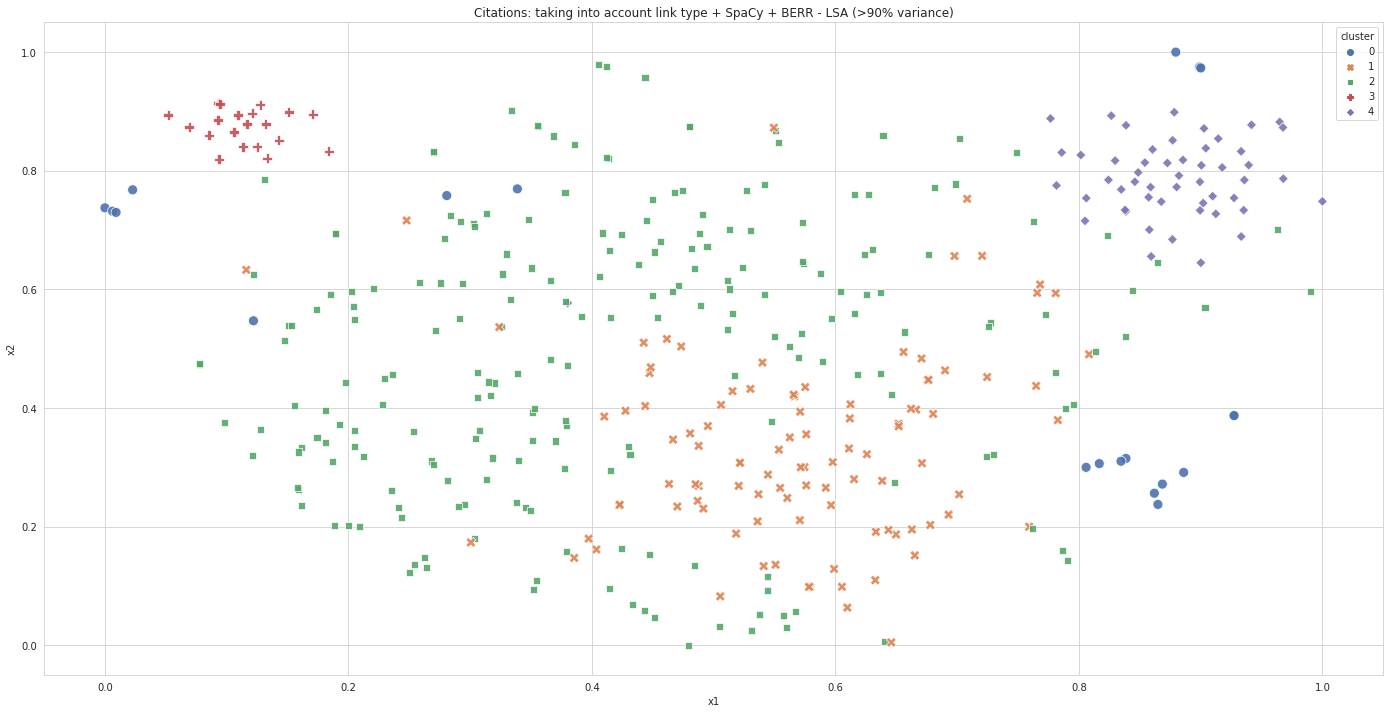

In [53]:
df_edges_and_spacy_and_bert_lsa_lsa = k_means(df_edges_and_spacy_and_bert_lsa_lsa, 'article_which_cities', N_CLUSTERS)
df_edges_and_spacy_and_bert_lsa_lsa_tsne, _ = get_TSNE_and_PCA_embeddings(df_edges_and_spacy_and_bert_lsa_lsa, 'article_which_cities')

fig, ax = plt.subplots(1, 1, figsize=(12*2,6*2))
ax.set_title('Citations: taking into account link type + SpaCy + BERR - LSA (>90% variance)')
sns.scatterplot(data=df_edges_and_spacy_and_bert_lsa_lsa_tsne, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax)


<AxesSubplot:title={'center':'Citations: taking into account link type + SpaCy + BERR + Year + citation count - LSA (>90% variance)'}, xlabel='x1', ylabel='x2'>

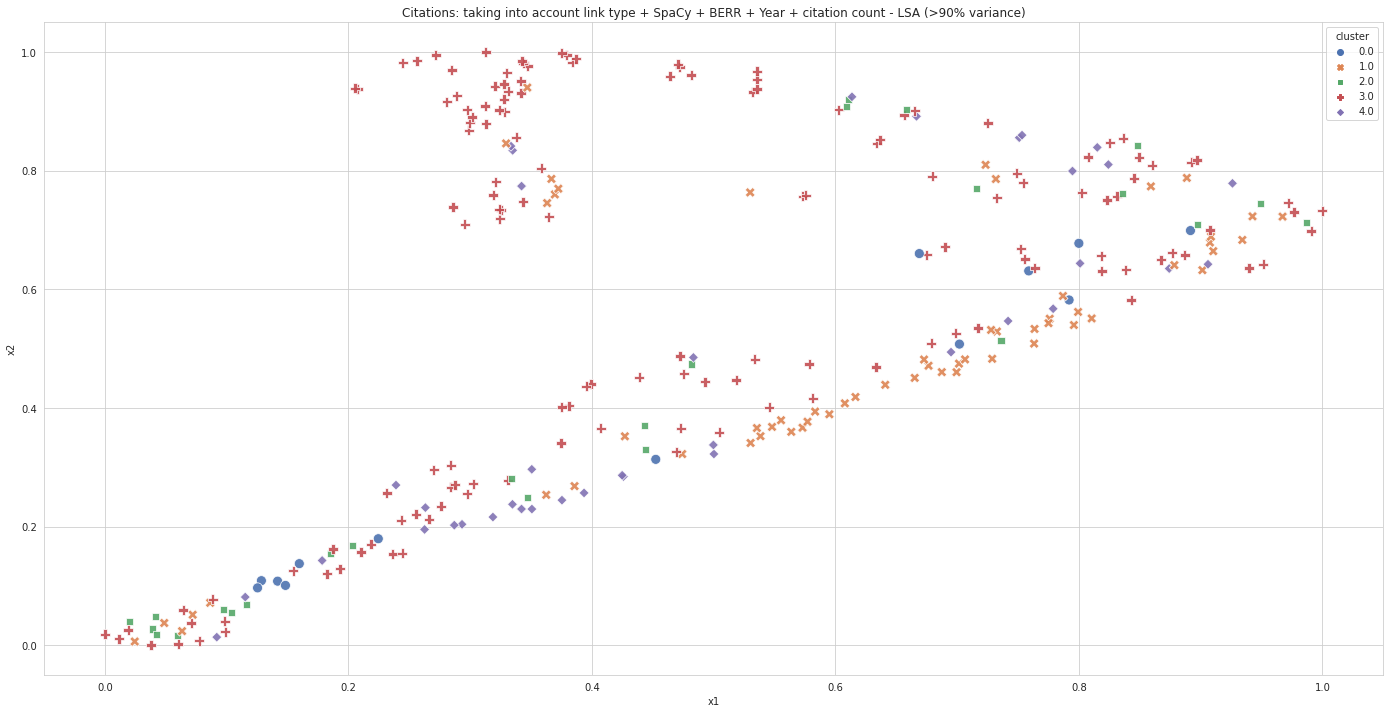

In [54]:
df_edges_and_spacy_and_bert_lsa_and_year_citation_c_lsa = k_means(df_edges_and_spacy_and_bert_lsa_and_year_citation_c_lsa, 'article_which_cities', N_CLUSTERS)
df_edges_and_spacy_and_bert_lsa_and_year_citation_c_lsa_tsne, df_edges_and_spacy_and_bert_lsa_and_year_citation_c_lsa_pca = get_TSNE_and_PCA_embeddings(df_edges_and_spacy_and_bert_lsa_and_year_citation_c_lsa, 'article_which_cities')

fig, ax = plt.subplots(1, 1, figsize=(12*2,6*2))
ax.set_title('Citations: taking into account link type + SpaCy + BERR + Year + citation count - LSA (>90% variance)')
sns.scatterplot(data=df_edges_and_spacy_and_bert_lsa_and_year_citation_c_lsa_tsne, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax)

In [126]:
# visualise_clusters(df_edges_and_spacy_and_bert_lsa_lsa_tsne, base_size=7*6, factor=1/7 * 1/200)

# Explanations
##

In [56]:
# TODO :
# Zamiast BERT - TF-IDF, W2V
# clamp -> objaśnie klustw
# expert clusters from Parisa  -> knAC
# inxai -> dodac NLU, metryki

## explain clusters on citations with abstracts

In [215]:
def add_cluster_col(df_nodes, df_with_cluster_kmeans_column):
  df_edges_for_xai = pd.merge(df_with_cluster_kmeans_column.loc[:, ['article_which_cities', 'cluster_kmeans']], df_nodes,
                              left_on='article_which_cities', right_on='ID')
  return df_edges_for_xai[[
    'article_which_cities', 'cluster_kmeans', 'Title', 'Abstract', 'AbstractCleaned', 'TitleAndAbstract', 'Year', 'CitationCount', 'RepetitionCount', 'YearCitationAndAbstractCleaned']]


In [ ]:
df_nodes_for_xai = add_cluster_col(df_nodes, df_edges_and_spacy_and_bert_lsa_lsa)
print(df_nodes_for_xai.info)
df_nodes_for_xai.dropna(inplace=True)
df_nodes_for_xai

In [59]:
cats = ['CitationCountLow', 'CitationCountMedium', 'CitationCountHigh']
quantiles = df_nodes_for_xai.loc[:, ['CitationCount']].quantile([0, 0.25, 0.75, 1.0])

for col in df_nodes_for_xai.loc[:, ['CitationCount']]:
  bin_edges = quantiles[col]
  # special case situations where all values are equal
  if bin_edges.nunique() == 1:
    df_nodes_for_xai[col+'Recoded'] = 'Low'
  else:
    df_nodes_for_xai[col+'Recoded'] = pd.cut(df_nodes_for_xai[col], bins=bin_edges, labels=cats, include_lowest=True)

df_nodes_for_xai['YearPubl'] = 'Year' + df_nodes_for_xai['Year'].astype(int).astype(str)

df_nodes_for_xai['YearCitationAndAbstractCleaned'] = df_nodes_for_xai['YearPubl'] + " " + \
                                                     df_nodes_for_xai['CitationCountRecoded'].astype(str) + " " + \
                                                     df_nodes_for_xai['AbstractCleaned']

df_nodes_for_xai.reset_index(inplace=True)

index article_which_cities  cluster_kmeans  \
0        0                  001               2   
1        1                  002               2   
2        2                  003               2   
3        3                  004               2   
4        4                  005               2   
..     ...                  ...             ...   
357    407                  494               4   
358    408                  495               3   
359    409                  497               3   
360    410                  498               4   
361    411                  500               4   

                                                 Title  \
0    "Why Should I Trust You?": Explaining the Pred...   
1    On Pixel-Wise Explanations for Non-Linear Clas...   
2    Towards A Rigorous Science of Interpretable Ma...   
3    A Unified Approach to Interpreting Model Predi...   
4              Axiomatic Attribution for Deep Networks   
..                                                 ...   
357                        Natural Language Processing   
358  Use of the 'Perceptron' algorithm to distingui...   
359  Skills, rules, and knowledge; signals, signs, ...   
360                            Building expert systems   
361  XPLAIN: A System for Creating and Explaining E...   

                                              Abstract  \
0    Despite widespread adoption, machine learning ...   
1    Understanding and interpreting classification ...   
2    As machine learning systems become ubiquitous,...   
3    Understanding why a model makes a certain pred...   
4    We study the problem of attributing the predic...   
..                                                 ...   
357  $&% ' () * + " , .*/ 0 . %% . 1 /. 1 '2 34 5 6...   
358  We have used a "Perceptron" algorithm to find ...   
359  The introduction of information technology bas...   
360  Reading,Mass.: Addison-Wesley Pub., 1983. 1: i...   
361  Traditional methods for explaining programs pr...   

                                       AbstractCleaned  \
0    despite widespread adoption machine learn rema...   
1    understand interpret classification decision a...   
2    machine learn system ubiquitous surge interest...   
3    understanding make certain prediction crucial ...   
4    study problem attribute prediction deep networ...   
..                                                 ...   
357  ba c ee f gih ejj kl e g n e h prq c e h ejmu ...   
358  perceptron algorithm find weight function dist...   
359  introduction information technology base digit...   
360  read mass addison wesley pub include bibliogra...   
361  traditional method explain program provide exp...   

                                      TitleAndAbstract    Year  CitationCount  \
0    "Why Should I Trust You?": Explaining the Pred...  2016.0         5799.0   
1    On Pixel-Wise Explanations for Non-Linear Clas...  2015.0         1848.0   
2    Towards A Rigorous Science of Interpretable Ma...  2017.0         1598.0   
3    A Unified Approach to Interpreting Model Predi...  2017.0         3798.0   
4    Axiomatic Attribution for Deep Networks We stu...  2017.0         1749.0   
..                                                 ...     ...            ...   
357  Natural Language Processing $&% ' () * + " , ....  1982.0         1229.0   
358  Use of the 'Perceptron' algorithm to distingui...  1982.0          624.0   
359  Skills, rules, and knowledge; signals, signs, ...  1983.0         3256.0   
360  Building expert systems Reading,Mass.: Addison...  1983.0         2261.0   
361  XPLAIN: A System for Creating and Explaining E...  1983.0          425.0   

     RepetitionCount CitationCountRecoded  YearPubl  \
0                 -1    CitationCountHigh  Year2016   
1                 -1    CitationCountHigh  Year2015   
2                 -1    CitationCountHigh  Year2017   
3                 -1    CitationCountHigh  Year2017   
4                 -1    CitationCountHigh  Year2017  

In [132]:
words_to_include_starting_list = list(set(df_nodes_for_xai['CitationCountRecoded'].unique().tolist() + df_nodes_for_xai['YearPubl'].unique().tolist()))

In [61]:
###  TODO
# mniej klastrow
# decision tree classfier
# potem odwrocic TF-IDF

In [ ]:
for cluster in range(0, N_CLUSTERS):
  print (f"cluster= {cluster}")
  # Start with one review:
  words = word_tokenize(" ".join(df_nodes_for_xai.loc[df_nodes_for_xai['cluster_kmeans'] == cluster, 'YearCitationAndAbstractCleaned'].tolist()))
  words = [w for w in words if not w.lower() in list(all_stopwords)]

  # vectorizer_for_wordcloud = TfidfVectorizer(max_features=700, stop_words=all_stopwords, min_df=2, max_df=.99, ngram_range=(1,3))
  # vectorizer_for_wordcloud.fit(words)
  # words = [w for w in words if w in vectorizer_for_wordcloud.get_feature_names()]

  # Create and generate a word cloud image:
  text = " ".join(words)
  wordcloud = WordCloud().generate(text)

  # Display the generated image:
  plt.figure(figsize=(15,15))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()
  # break

In [65]:
## TODO
# LDA instead of k-means (?)
# k-means: add bert/spacy LSA


# - Use expert knowledge??
# - Use citations : cluster 1 == cities_art_12
#   - common words in abstract for cluster (~ TFID)
# USE year_2020 etc

# Wizualizacja - czym różnią się clustry:
# - word cloud dla clustra + polaczenia między clustrami - czym się różnią

# Counterfactual

## Iterative approach

In [300]:
class Pipeline:

  def __init__(self, df: pd.DataFrame, key: str):
    self.df = df
    self.key = key
    self.clusters_count:Optional[int] = None
    self.df_tsne:Optional[pd.DataFrame] = None
    self.df_pca:Optional[pd.DataFrame] = None
    self.text_column:Optional[str] = None
    self.clf = None
    self.df_nodes_for_xai:Optional[pd.DataFrame] = None
    self.explainer:  Optional[LimeTextExplainer] = None
    self.c = None
    self.stop_words = None
    self.words_to_include = None
    self.clusters:Optional[List[int]] = None

  def fit(self, clusters_count: int):
    self.clusters_count = clusters_count
    self.df = k_means(self.df, self.key, clusters_count)
    self.df_tsne, self.df_pca = get_TSNE_and_PCA_embeddings(self.df, self.key)

    fig, ax = plt.subplots(1, 2, figsize=(12 * 2, 5 * 2))
    ax[0].set_title('TSNE')
    sns.scatterplot(data=self.df_tsne, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax[0])
    ax[1].set_title('PCA')
    sns.scatterplot(data=self.df_pca, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax[1])

  def visualise_clustering(self):
    if self.clusters_count:
      visualise_clusters(self.df_tsne, base_size=7*6, factor=1/7 * 1/200)

  def explain(self, df_nodes_for_xai: pd.DataFrame, text_column:str, features_count:int,
      stop_words: Optional[List[str]] = None, words_to_include: Optional[List[str]] = None):
    self.text_column = text_column
    self.stop_words = stop_words
    self.words_to_include = words_to_include

    self.df_nodes_for_xai = df_nodes_for_xai
    if 'cluster_kmeans' in self.df_nodes_for_xai.columns:
      del self.df_nodes_for_xai['cluster_kmeans']
    self.df_nodes_for_xai.rename(columns={'article_which_cities' : 'ID'}, inplace=True)
    self.df_nodes_for_xai = add_cluster_col(df_nodes_for_xai, self.df)
    # print(self.df_nodes_for_xai.info())
    self.clusters = self.df_nodes_for_xai['cluster_kmeans'].astype(str).unique().tolist()
    self.clusters.sort()
    print(f"clusters= {self.clusters}")

    train, test, train_labels, test_labels = train_test_split(
      self.df_nodes_for_xai[text_column], self.df_nodes_for_xai['cluster_kmeans'], test_size=.2, shuffle=True)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    vectorizer = TfidfVectorizer(max_features=features_count, stop_words=self.stop_words, min_df=5, max_df=.05, ngram_range=(1, 5))
    vectorizer.fit(train)
    top_features = vectorizer.vocabulary_
    print(f"Explanations will use: {[x for x in top_features.keys()]}")
    for index, feature in enumerate(self.words_to_include):
      top_features[feature] = features_count + index

    self.vectorizer = TfidfVectorizer(vocabulary=top_features)
    self.vectorizer.fit(train)
    self.clf = DecisionTreeClassifier()
    self.clf.fit(self.vectorizer.transform(train), train_labels)
    predict_fn = lambda x: self.clf.predict(self.vectorizer.transform(x))

    preds_train = predict_fn(train)
    preds_test = predict_fn(test)
    print('Train accuracy', accuracy_score(train_labels, preds_train))
    print('Test accuracy', accuracy_score(test_labels, preds_test))

    print(classification_report(test_labels, preds_test))
    print('Confusion Matrix:',)
    print(confusion_matrix(test_labels, preds_test))

    plt.figure(figsize=(3*16, 2*8))
    tree.plot_tree(self.clf, feature_names = self.vectorizer.get_feature_names(), class_names = self.clusters, max_depth=5, fontsize=9, proportion=True, filled=True, rounded=True)

  def lime_example(self):
    if not self.explainer:
      self.explainer = LimeTextExplainer(class_names=self.clf.classes_)
      self.c = make_pipeline(self.vectorizer, self.clf)

    random_index = randint(0, len(self.df_nodes_for_xai)-1)
    _cluster_kmeans = self.df_nodes_for_xai.loc[random_index, 'cluster_kmeans']
    _text_to_expl = self.df_nodes_for_xai.loc[random_index, self.text_column]
    # print(f"Cluster= {_cluster_kmeans}, text= {_text_to_expl}")
    self.explainer.explain_instance(_text_to_expl, self.c.predict_proba, num_features=5, labels=(_cluster_kmeans,)).show_in_notebook()

  def word_cloud(self):
    for cluster in self.clusters:
      print (f"cluster= {cluster}")
      # Start with one review:
      # print(self.df_nodes_for_xai.loc[self.df_nodes_for_xai['cluster_kmeans'].astype(str) == cluster, self.text_column].tolist())
      words = word_tokenize(" ".join(self.df_nodes_for_xai.loc[self.df_nodes_for_xai['cluster_kmeans'].astype(str) == cluster, self.text_column].tolist()))
      words = [w for w in words if not w.lower() in list(self.stop_words)]

      # Create and generate a word cloud image:
      # text = " ".join(words)

      vectorizer = TfidfVectorizer(max_features=1000, stop_words=self.stop_words, min_df=5, max_df=.20, ngram_range=(1, 5))
      response = vectorizer.fit_transform(words)
      df_tfidf_sklearn = pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names())
      tf_idf_counter = df_tfidf_sklearn.T.sum(axis=1)

      # print(text)
      wordcloud = WordCloud(background_color='white').generate_from_frequencies(tf_idf_counter)

      # Display the generated image:
      plt.figure(figsize=(15,15))
      plt.imshow(wordcloud, interpolation='bilinear')
      plt.axis("off")
      plt.show()


## given:

In [224]:
df_nodes_for_xai#[['article_which_cities', 'Title', 'YearCitationAndAbstractCleaned']]

index   ID                                              Title  \
0        0  001  "Why Should I Trust You?": Explaining the Pred...   
1        1  002  On Pixel-Wise Explanations for Non-Linear Clas...   
2        2  003  Towards A Rigorous Science of Interpretable Ma...   
3        3  004  A Unified Approach to Interpreting Model Predi...   
4        4  005            Axiomatic Attribution for Deep Networks   
..     ...  ...                                                ...   
357    407  494                        Natural Language Processing   
358    408  495  Use of the 'Perceptron' algorithm to distingui...   
359    409  497  Skills, rules, and knowledge; signals, signs, ...   
360    410  498                            Building expert systems   
361    411  500  XPLAIN: A System for Creating and Explaining E...   

                                              Abstract  \
0    Despite widespread adoption, machine learning ...   
1    Understanding and interpreting classification ...   
2    As machine learning systems become ubiquitous,...   
3    Understanding why a model makes a certain pred...   
4    We study the problem of attributing the predic...   
..                                                 ...   
357  $&% ' () * + " , .*/ 0 . %% . 1 /. 1 '2 34 5 6...   
358  We have used a "Perceptron" algorithm to find ...   
359  The introduction of information technology bas...   
360  Reading,Mass.: Addison-Wesley Pub., 1983. 1: i...   
361  Traditional methods for explaining programs pr...   

                                       AbstractCleaned  \
0    despite widespread adoption machine learn rema...   
1    understand interpret classification decision a...   
2    machine learn system ubiquitous surge interest...   
3    understanding make certain prediction crucial ...   
4    study problem attribute prediction deep networ...   
..                                                 ...   
357  ba c ee f gih ejj kl e g n e h prq c e h ejmu ...   
358  perceptron algorithm find weight function dist...   
359  introduction information technology base digit...   
360  read mass addison wesley pub include bibliogra...   
361  traditional method explain program provide exp...   

                                      TitleAndAbstract    Year  CitationCount  \
0    "Why Should I Trust You?": Explaining the Pred...  2016.0         5799.0   
1    On Pixel-Wise Explanations for Non-Linear Clas...  2015.0         1848.0   
2    Towards A Rigorous Science of Interpretable Ma...  2017.0         1598.0   
3    A Unified Approach to Interpreting Model Predi...  2017.0         3798.0   
4    Axiomatic Attribution for Deep Networks We stu...  2017.0         1749.0   
..                                                 ...     ...            ...   
357  Natural Language Processing $&% ' () * + " , ....  1982.0         1229.0   
358  Use of the 'Perceptron' algorithm to distingui...  1982.0          624.0   
359  Skills, rules, and knowledge; signals, signs, ...  1983.0         3256.0   
360  Building expert systems Reading,Mass.: Addison...  1983.0         2261.0   
361  XPLAIN: A System for Creating and Explaining E...  1983.0          425.0   

     RepetitionCount CitationCountRecoded  YearPubl  \
0                 -1    CitationCountHigh  Year2016   
1                 -1    CitationCountHigh  Year2015   
2                 -1    CitationCountHigh  Year2017   
3                 -1    CitationCountHigh  Year2017   
4                 -1    CitationCountHigh  Year2017   
..               ...                  ...       ...   
357               -1    CitationCountHigh  Year1982   
358               -1  CitationCountMedium  Year1982   
359               -1    CitationCountHigh  Year1983   
360               -1    CitationCountHigh  Year1983   
361               -1  CitationCountMedium  Year1983   

                        YearCitationAndAbstractCleaned  
0    Year2016 CitationCountHigh despite widespread ...  
1    Year2015 Citation

In [225]:
print(words_to_include_starting_list)

['Year2009', 'Year2003', 'Year1983', 'Year1981', 'Year2011', 'Year1936', 'Year1975', 'Year1988', 'Year1995', 'Year2015', 'Year2018', 'Year1998', 'Year2019', 'Year2012', 'Year2006', 'Year2013', 'Year2016', 'Year2008', 'CitationCountLow', 'Year2007', 'Year1994', 'Year2000', 'Year2020', 'Year1986', 'Year2005', 'Year1974', 'Year1977', 'Year1996', 'Year1970', 'CitationCountHigh', 'Year2017', 'Year1961', 'CitationCountMedium', 'Year2010', 'Year1979', 'Year1982', 'Year1999', 'Year2004', 'Year1997', 'Year2014', 'Year1973', 'Year2001', 'Year1992', 'Year1976', 'Year2002', 'Year1987', 'Year1890', 'Year1938', 'Year1980', 'Year1948']


In [235]:
user_defined_stopwords = spacy_nlp_model.Defaults.stop_words
# print(len(user_defined_stopwords))
# print('approach' in user_defined_stopwords)
user_defined_stopwords.update(stopwords.words('english'))
# print(len(user_defined_stopwords))
print(list(user_defined_stopwords)[:100])

['them', 'regarding', 'put', 'used', 'toward', 'answer', 'go', 'unless', 'latter', 'among', 'perhaps', 'hereby', "mightn't", 'than', 'over', 'some', 'towards', 'own', 'my', 'just', 'forty', 'on', 'has', 'al', 'thence', 'call', 'part', 'amount', '‘ve', "'re", 'yet', 'hereafter', 'throughout', "weren't", 'nowhere', '‘s', 'nevertheless', 'bottom', 'if', 'both', 'keep', 'below', 'few', 'seems', 'won', 'third', 'ours', 'seemed', 'this', 'whom', 'ain', 'can', 'seeming', 'really', 'hers', 'him', 'while', 'up', 'thereupon', 'shouldn', 'afterwards', 'was', 'become', 'their', 'do', 'someone', 'only', 'd', 'everywhere', 'her', 'hadn', 'six', 'last', 'ten', 'side', 'did', 'too', 'becoming', 're', 'two', '’s', "shan't", 's', "that'll", 'moreover', 'across', 'somewhere', 'latterly', 'i', 'then', 'hereupon', 'make', 'by', 'alone', 'm', 'fifty', 'give', 'every', "'ve", "you'll"]


## STEP 1

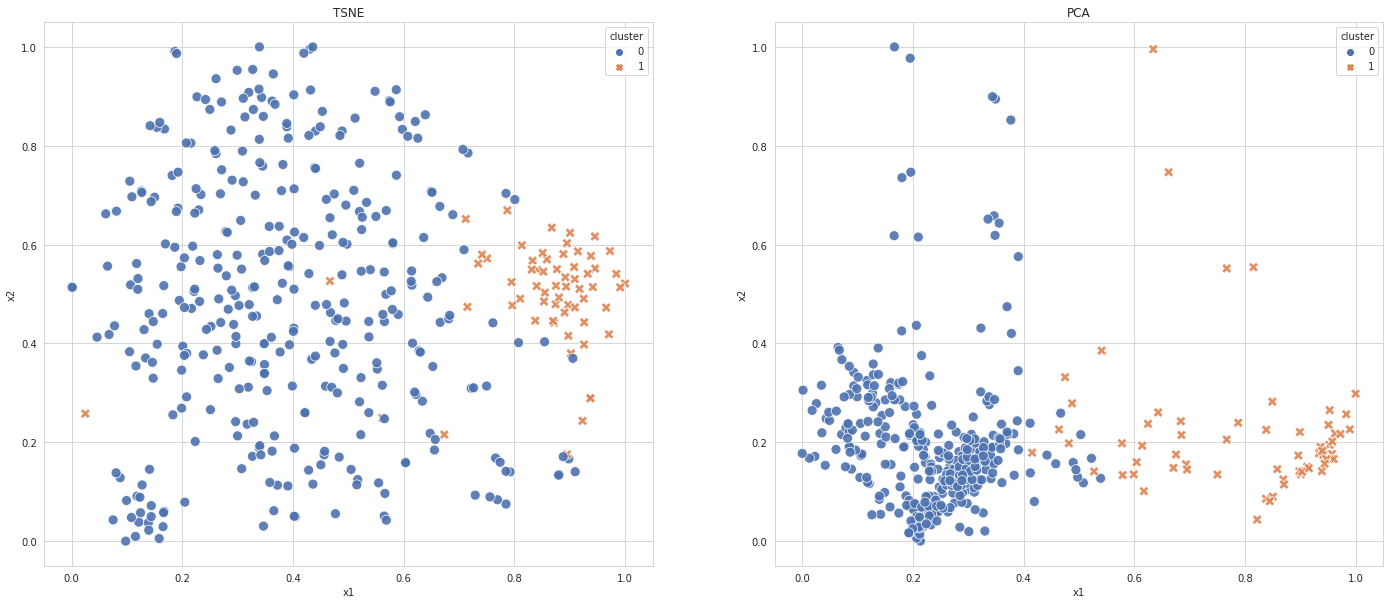

In [236]:
citations_pipeline = Pipeline(df_edges_and_spacy_and_bert_lsa_lsa, key = 'article_which_cities')
citations_pipeline.fit(2)

In [228]:
# citations_pipeline.visualise_clustering() ## OK

Explanations will use: ['generative', 'participant', 'plot', 'cnn', 'cnns', 'cluster', 'evidence', 'agent', 'attribute', 'explainability', 'graph', 'neuron', 'dnns', 'response', 'instance', 'rule extraction', 'perturbation', 'inference', 'sample', 'filter']
Train accuracy 0.8581314878892734
Test accuracy 0.8904109589041096
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        66
           1       0.33      0.14      0.20         7

    accuracy                           0.89        73
   macro avg       0.62      0.56      0.57        73
weighted avg       0.86      0.89      0.87        73

Confusion Matrix:
[[64  2]
 [ 6  1]]


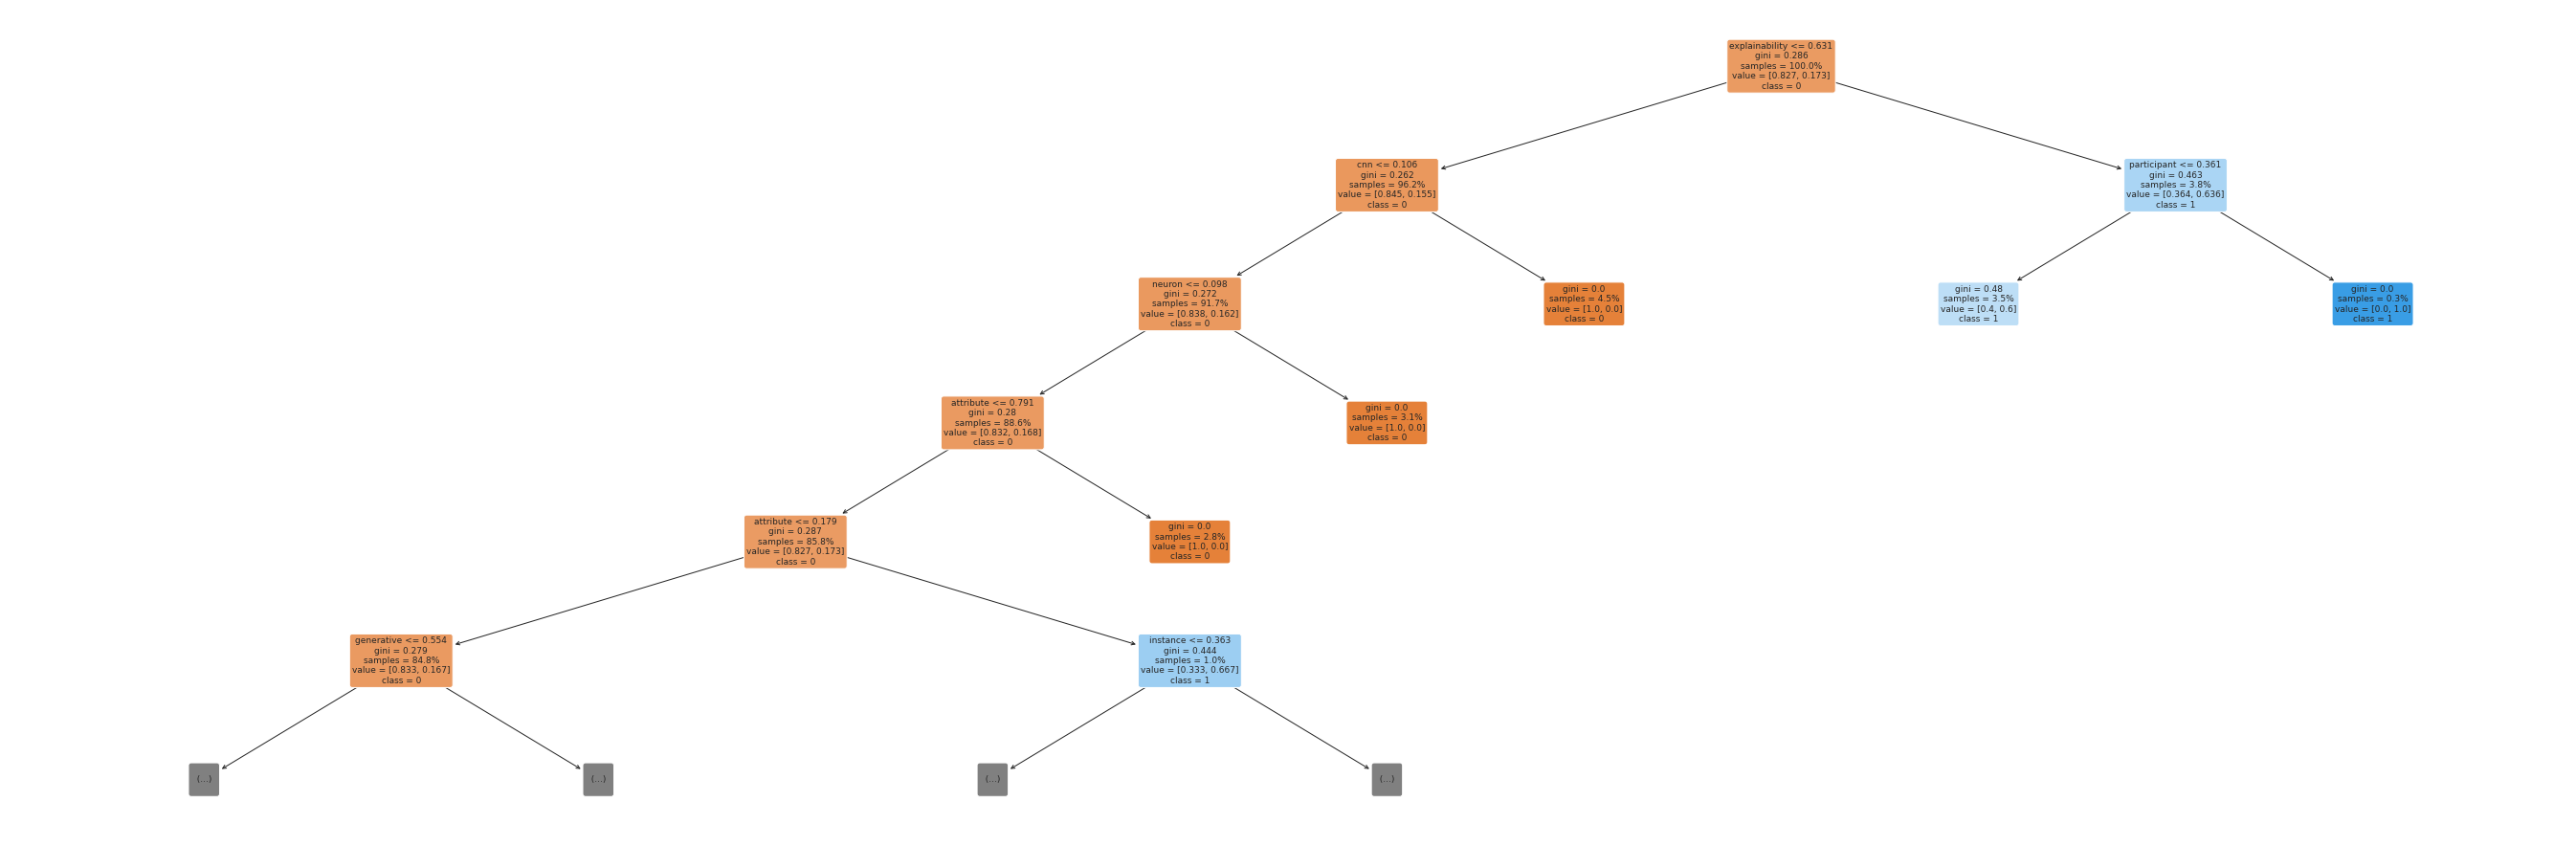

In [237]:
citations_pipeline.explain(df_nodes_for_xai, 'YearCitationAndAbstractCleaned', 20, stop_words = user_defined_stopwords, words_to_include = words_to_include_starting_list)

In [238]:
citations_pipeline.lime_example()

# STEP 2

392
True
Explanations will use: ['cnn', 'cnns', 'xai', 'agent', 'direction', 'rule extraction', 'instance', 'dnns', 'inference', 'comprehensibility', 'people', 'adversarial', 'sample', 'graph', 'evidence', 'explainability', 'unit', 'weight', 'saliency', 'cluster']
Train accuracy 0.8927335640138409
Test accuracy 0.7397260273972602
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        60
           1       0.12      0.08      0.10        13

    accuracy                           0.74        73
   macro avg       0.47      0.48      0.47        73
weighted avg       0.69      0.74      0.71        73

Confusion Matrix:
[[53  7]
 [12  1]]


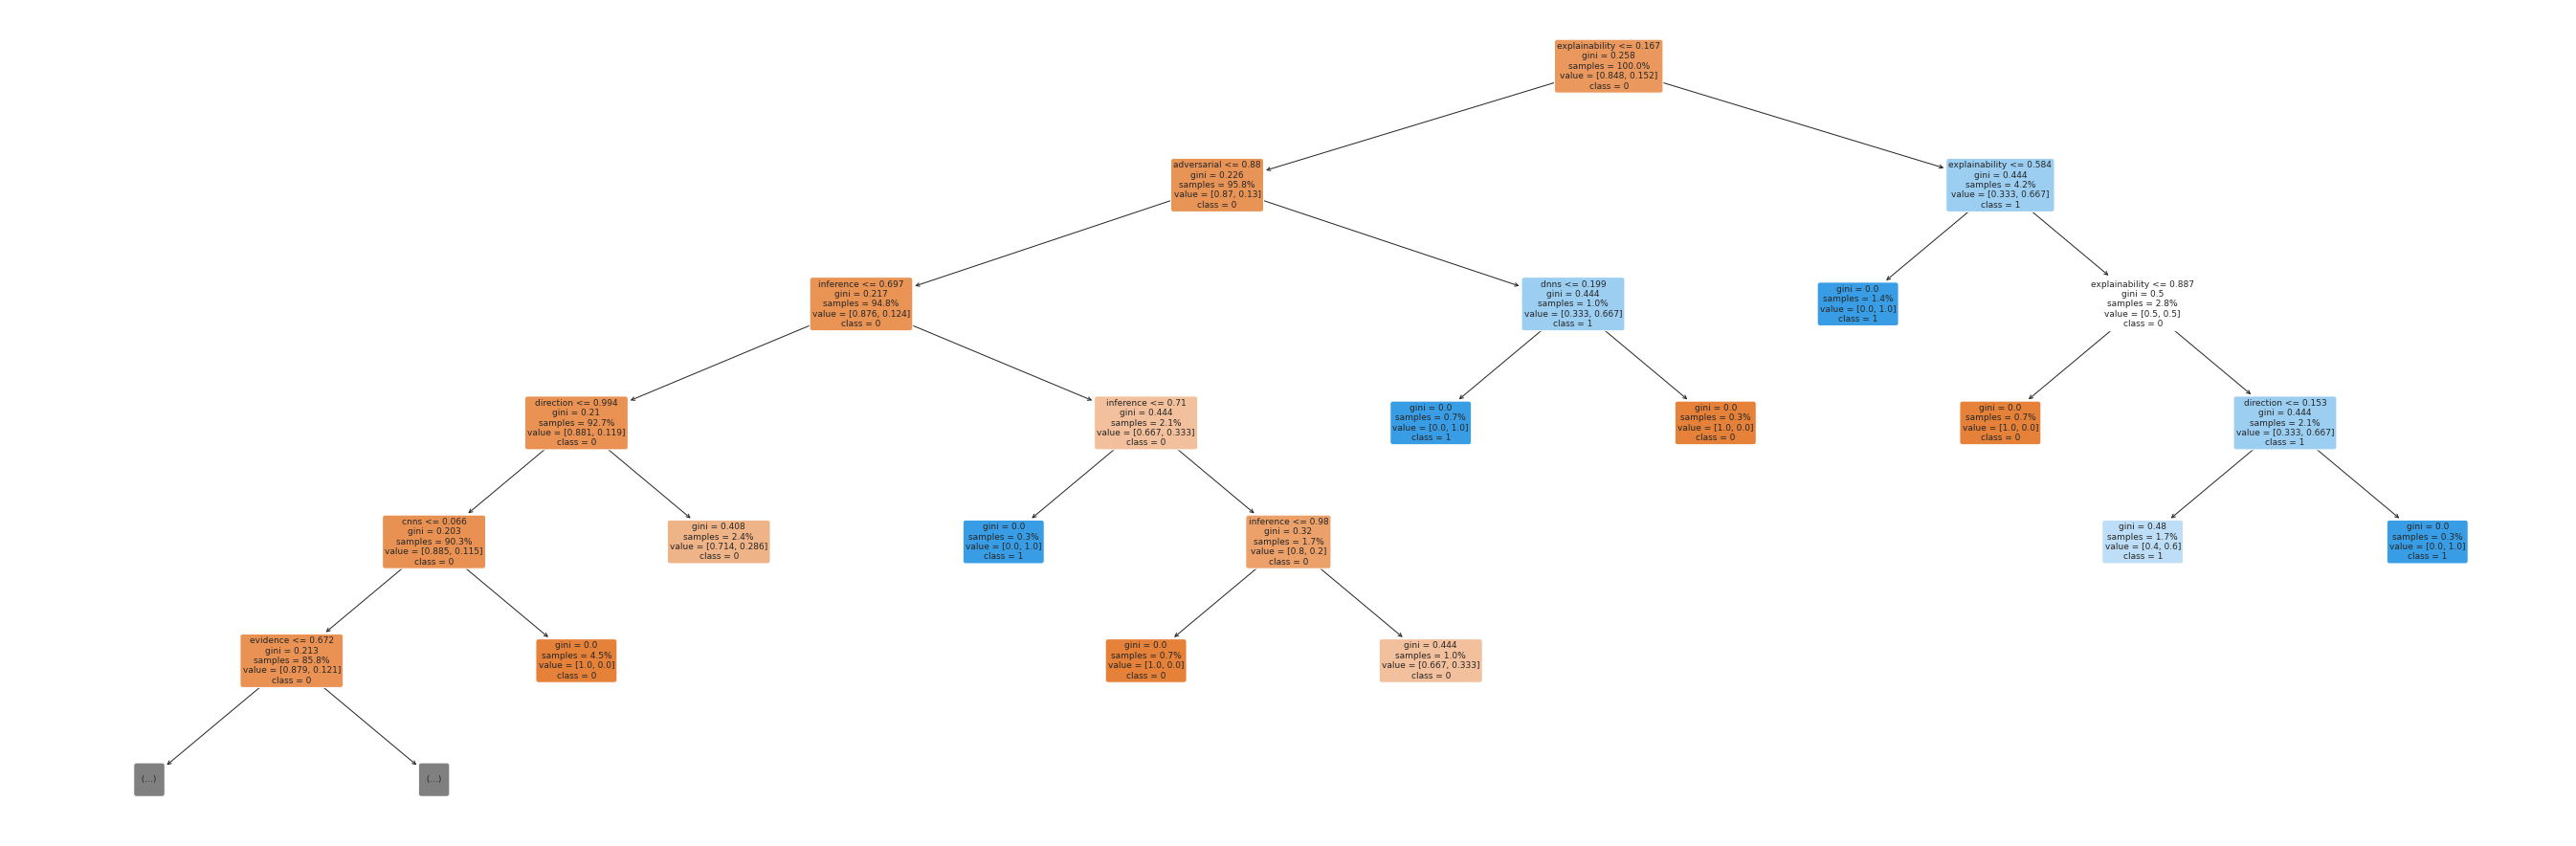

In [239]:
user_defined_stopwords.update(['participant'])
print(len(user_defined_stopwords))
print('code' in user_defined_stopwords)

citations_pipeline.explain(df_nodes_for_xai, 'YearCitationAndAbstractCleaned', 20, stop_words = user_defined_stopwords, words_to_include = words_to_include_starting_list)

In [240]:
citations_pipeline.lime_example()

# STEP 3

Explanations will use: ['evidence', 'filter', 'explainability', 'xai', 'unit', 'cluster', 'prototype', 'dnns', 'estimate', 'comprehensibility', 'direction', 'adversarial', 'plan', 'instance', 'agent', 'plot', 'cnn', 'graph', 'deep learning', 'counterfactual']
Train accuracy 0.8823529411764706
Test accuracy 0.821917808219178
              precision    recall  f1-score   support

           0       0.83      0.98      0.90        61
           1       0.00      0.00      0.00        12

    accuracy                           0.82        73
   macro avg       0.42      0.49      0.45        73
weighted avg       0.70      0.82      0.75        73

Confusion Matrix:
[[60  1]
 [12  0]]


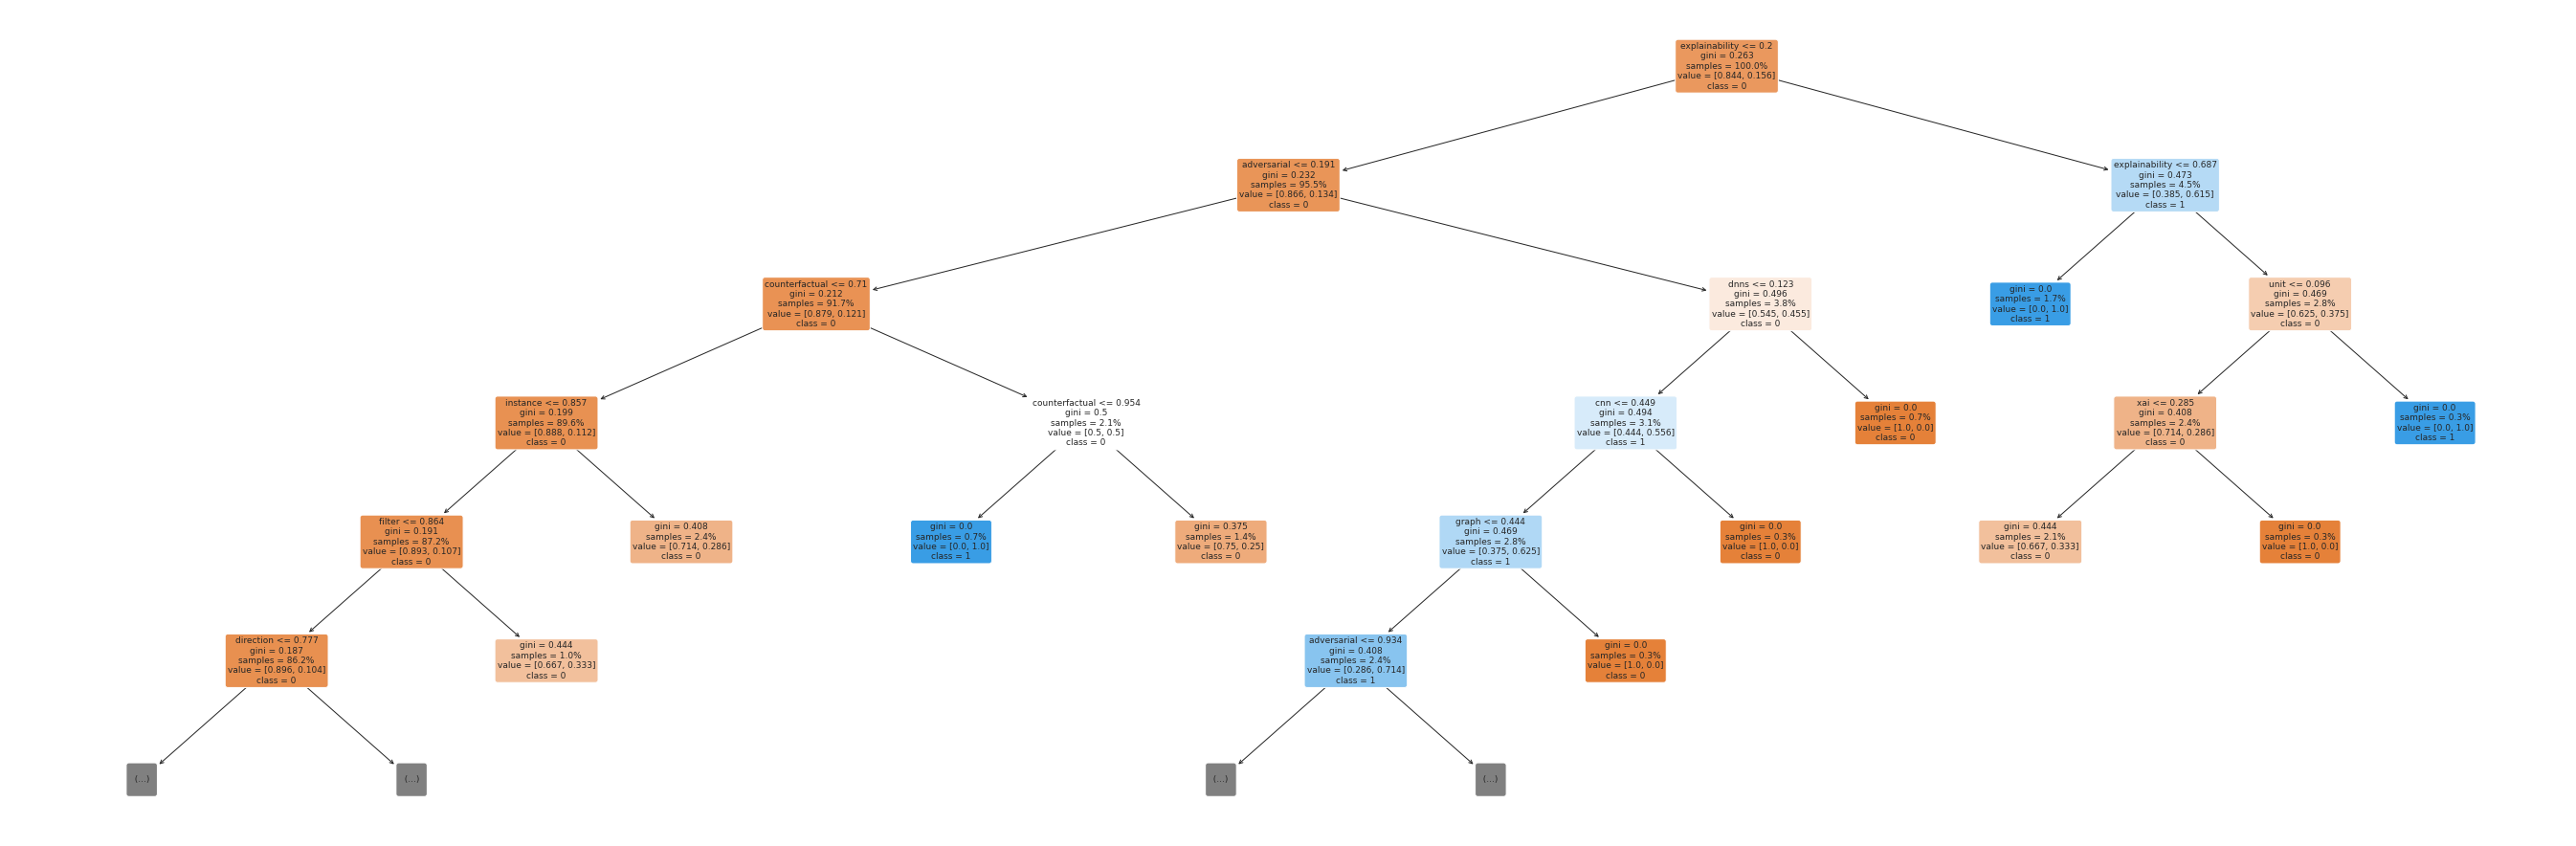

In [241]:
user_defined_stopwords.update(['paper', 'propose', 'novel'])

citations_pipeline.explain(df_nodes_for_xai, 'YearCitationAndAbstractCleaned', 20, stop_words = user_defined_stopwords, words_to_include = words_to_include_starting_list)

In [242]:
citations_pipeline.lime_example()

# STEP 5

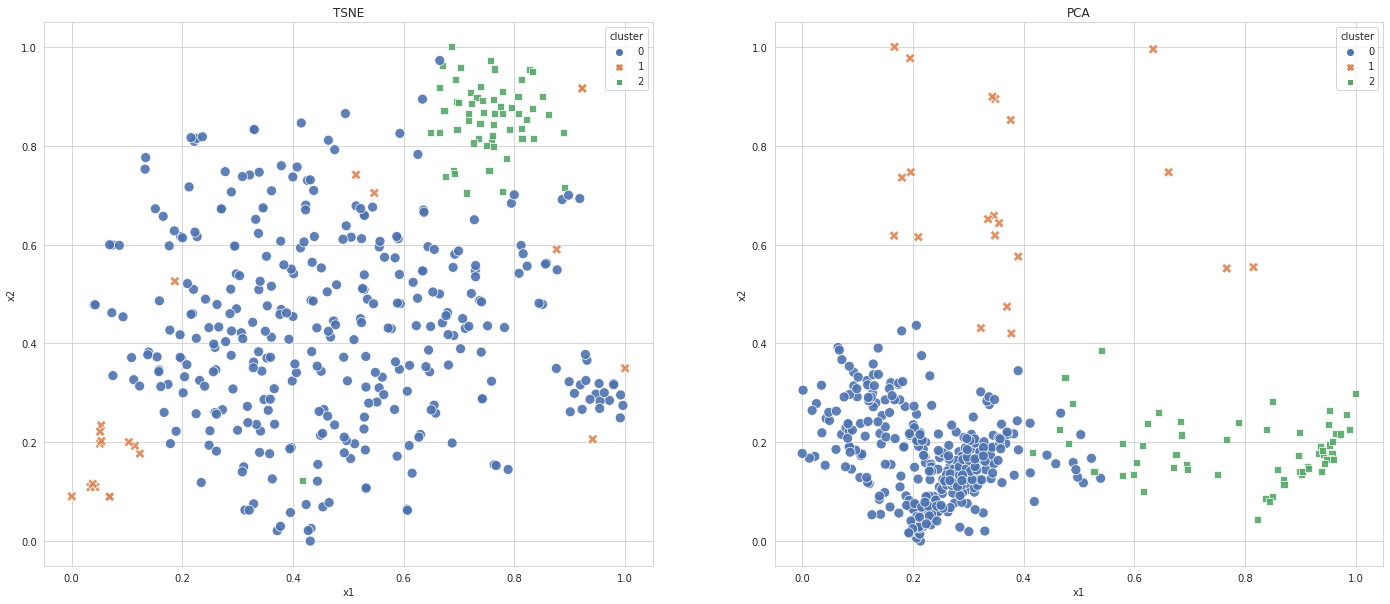

In [301]:
citations_pipeline = Pipeline(df_edges_and_spacy_and_bert_lsa_lsa, key = 'article_which_cities')
citations_pipeline.fit(3)

clusters= ['0', '1', '2']
Explanations will use: ['xai', 'filter', 'net', 'activation', 'attribute', 'cluster', 'generative', 'inference', 'dnns', 'instance', 'cnns', 'unit', 'cnn', 'evidence', 'interaction', 'explainability', 'agent', 'plan', 'graph', 'explanatory']
Train accuracy 0.8269896193771626
Test accuracy 0.8082191780821918
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        59
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        11

    accuracy                           0.81        73
   macro avg       0.27      0.33      0.30        73
weighted avg       0.66      0.81      0.73        73

Confusion Matrix:
[[59  0  0]
 [ 3  0  0]
 [10  1  0]]


/home/mmozolewski/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mmozolewski/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mmozolewski/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


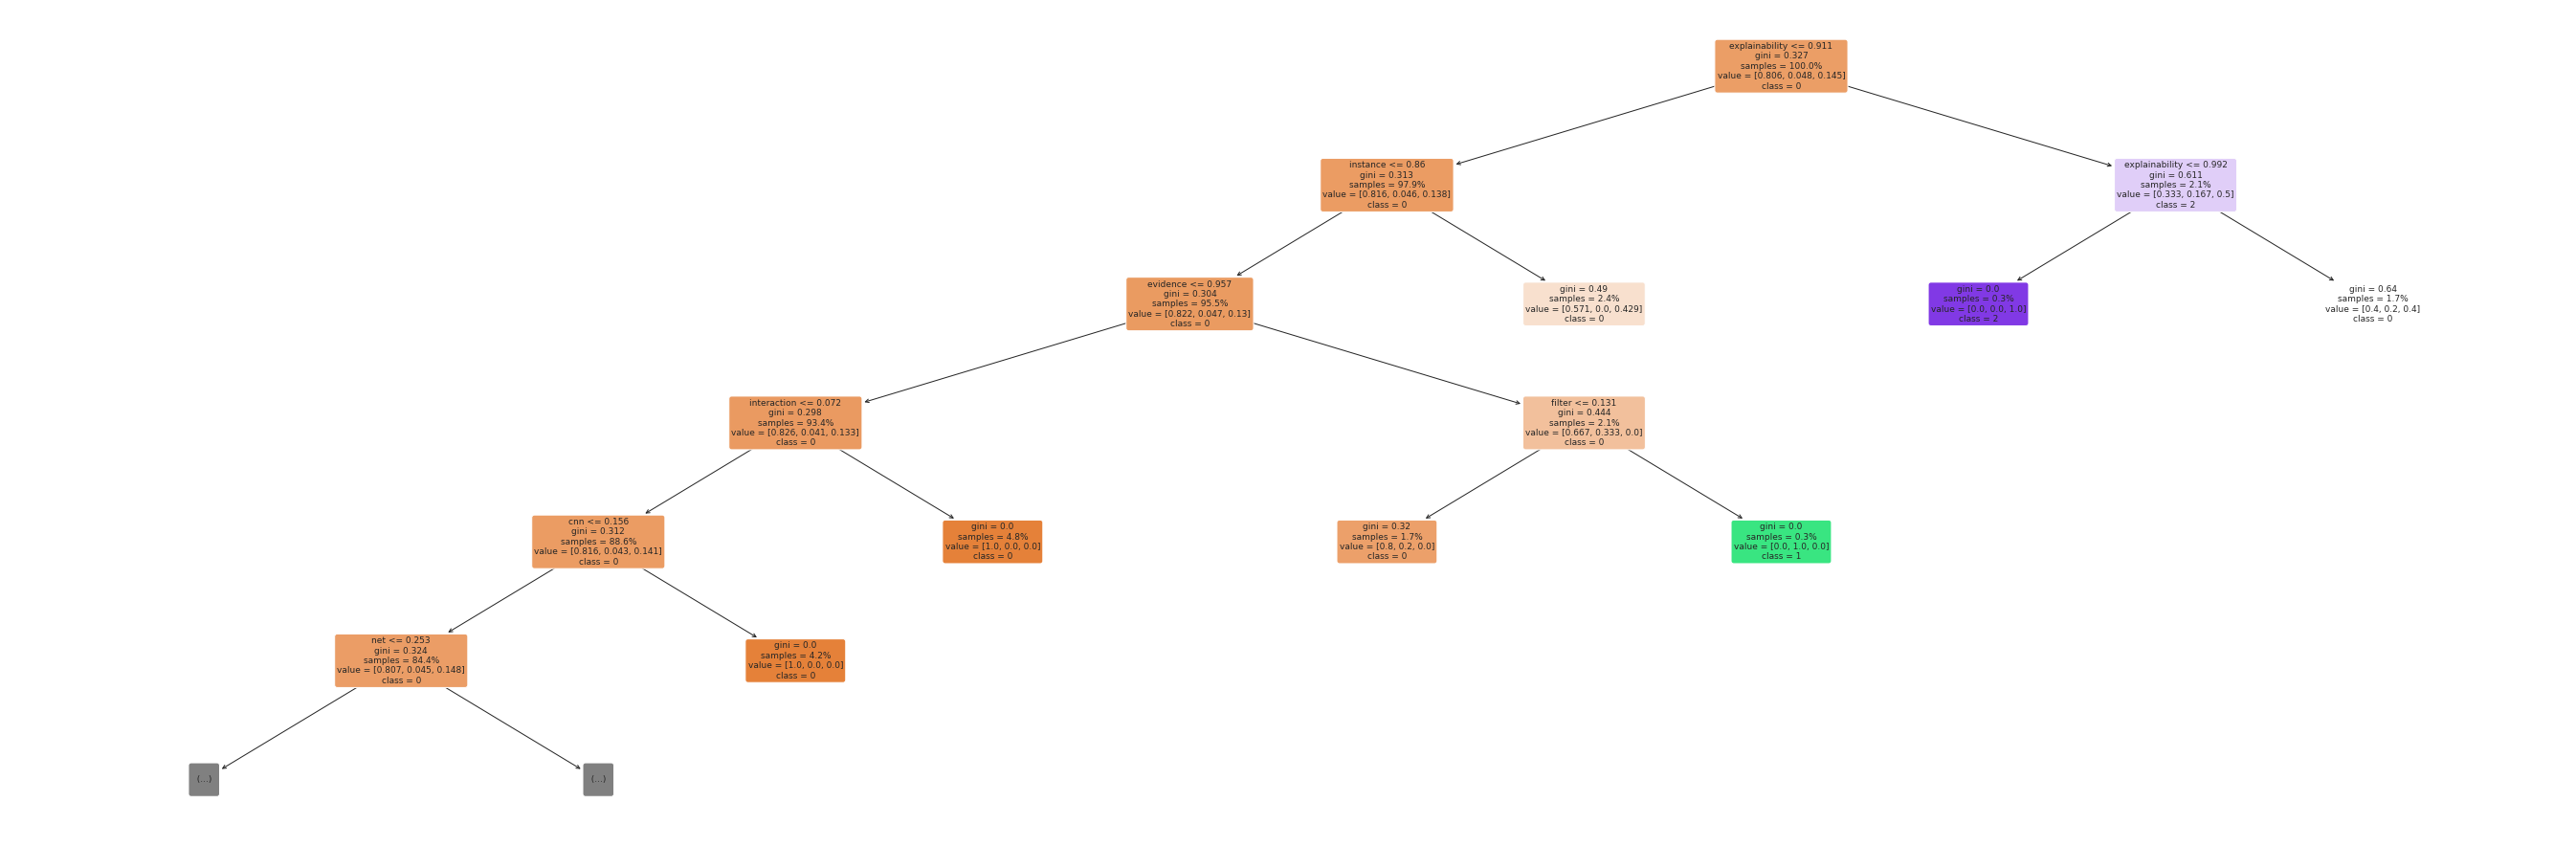

In [302]:
citations_pipeline.explain(df_nodes_for_xai, 'YearCitationAndAbstractCleaned', 20, stop_words = user_defined_stopwords, words_to_include = words_to_include_starting_list)

In [303]:
citations_pipeline.lime_example()

cluster= 0


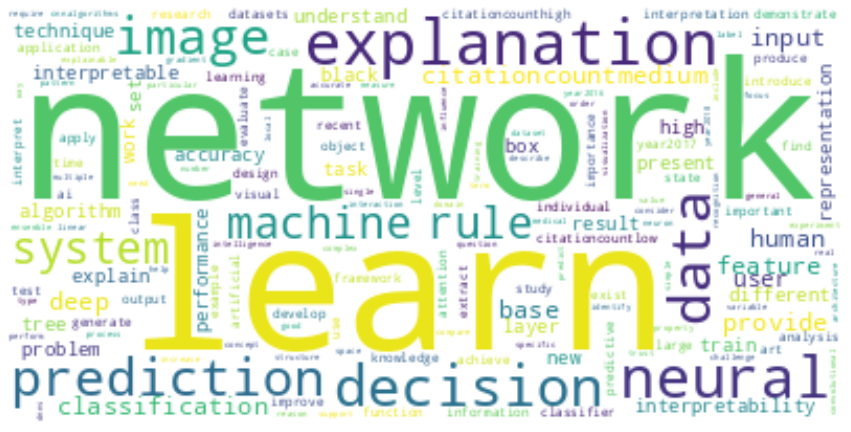

cluster= 1


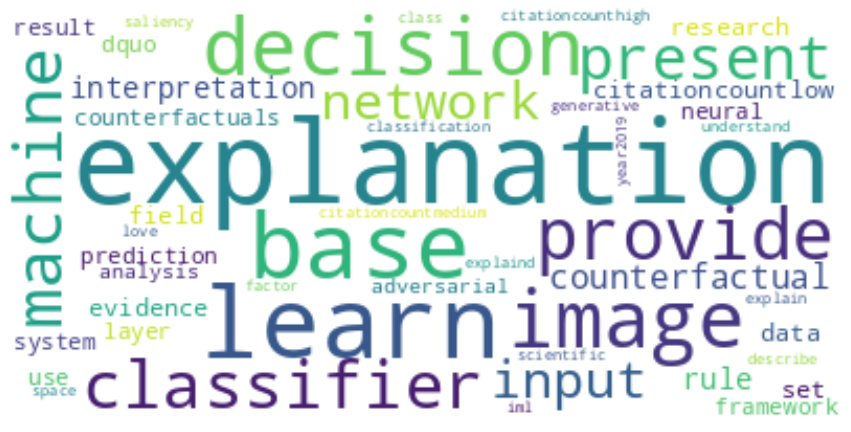

cluster= 2


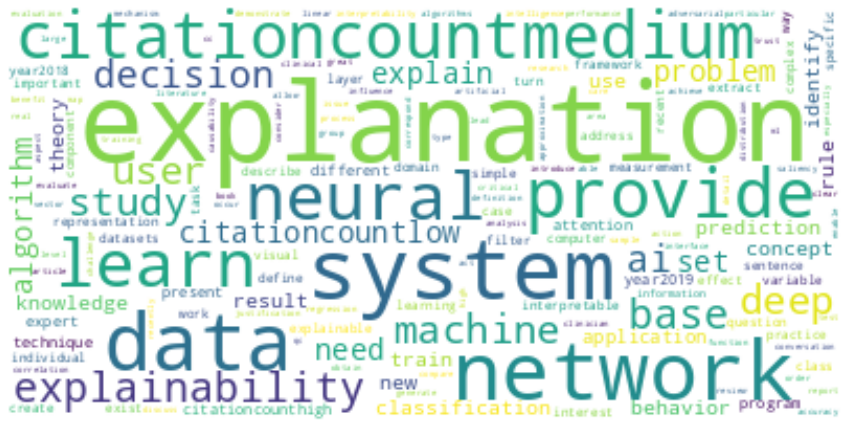

In [304]:
citations_pipeline.word_cloud() ## TODO use tfidf in word_clouds

## future works:
- https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html